In [19]:
import os,sys
%matplotlib inline

import pandas as pd
import numpy as np
from itertools import cycle, islice

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from statannot import add_stat_annotation

from scipy import stats 
import PyComplexHeatmap
from PyComplexHeatmap import *
import warnings
warnings.filterwarnings(action='ignore')

print(matplotlib.__version__)
print(sns.__version__)
print(PyComplexHeatmap.__version__)

3.7.3
0.12.2
1.6.2


# Import data

In [20]:
PPGR_meal_merged = pd.read_csv('../data/PPGR_meal_merged_cont2.csv',index_col=0)

CGM_post120_col = list(PPGR_meal_merged.columns[71:96])
CGM_post240_col = list(PPGR_meal_merged.columns[71:120])

PPGR_meal_merged[CGM_post240_col] = PPGR_meal_merged.loc[:,CGM_post240_col].interpolate(axis=1)
G0 = PPGR_meal_merged['p_000']

cgm_cols = list(PPGR_meal_merged.columns[71:120])

iAUC_2h = [0]*len(PPGR_meal_merged)
for i in range(1,25):
    Gi = PPGR_meal_merged[CGM_post120_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post120_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_2h+=Si*5
    
iAUC_4h = [0]*len(PPGR_meal_merged)
for i in range(1,49):
    Gi = PPGR_meal_merged[CGM_post240_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post240_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_4h+=Si*5
    
    
PPGR_meal_merged['PPGR_u2'] = iAUC_2h/60
PPGR_meal_merged['PPGR_u4'] = iAUC_4h/60

In [21]:
PPGR_meal_merged_filt = PPGR_meal_merged.dropna(subset=['meal_m1'],axis=0)
PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged['Energy(kcal)']<2000) & (PPGR_meal_merged['Carb(g)']<250)]
PPGR_meal_merged_filt['Carb_root'] = PPGR_meal_merged_filt['Carb(g)']**(1/2)
PPGR_meal_merged_filt['Protein_root'] = PPGR_meal_merged_filt['Protein(g)']**(1/2)
PPGR_meal_merged_filt['Fat_root'] = PPGR_meal_merged_filt['Fat(g)']**(1/2)
PPGR_meal_merged_filt['Carb_pro'] = PPGR_meal_merged_filt['Carb(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Protein_pro'] = PPGR_meal_merged_filt['Protein(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Fat_pro'] = PPGR_meal_merged_filt['Fat(g)']*9 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100

OTU_data = pd.read_csv('../data/T2D_KBSMC_otu_norm.csv',index_col=0)
OTU_data_bc = pd.DataFrame(stats.boxcox(OTU_data,lmbda=0.25),columns=OTU_data.columns,index=OTU_data.index)
med_data = pd.read_excel('../data/CGM Nutrition_CRF_Medication.xlsx')
clinical_data = pd.read_excel('../data/CGM Nutrition_CRF_20230808_추가Lab.xlsx')

CGM_pre90_col = list(PPGR_meal_merged_filt.columns[53:72]) #19
CGM_pre60_col = list(PPGR_meal_merged_filt.columns[59:72]) #13
CGM_pre30_col = list(PPGR_meal_merged_filt.columns[65:72]) #7
CGM_post120_col = list(PPGR_meal_merged_filt.columns[71:96])
CGM_post240_col = list(PPGR_meal_merged_filt.columns[71:120])

        
PPGR_data =  PPGR_meal_merged_filt.dropna(subset=['PPGR_u2','PPGR_u4']+CGM_pre30_col,axis=0)
        
PPGR = 'PPGR_u2'
PPGR_4 = 'PPGR_u4'
meal_composition = ['Carb_root','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)','Carb_pro','Protein_pro','Fat_pro']
meal_context = ['meal_m1','prot_b6h','Time']
cli_col = ['Age','DM_Duration','BMI','HbA1c','SBP','DBP','HDL','LDL','AST(IU/L)','ALT(IU/L)'] #cli_col = ['Age','DM_Duration','BMI','Weight(kg)','Waist_Circumference(cm)','SBP','DBP','FBS','HbA1c','Total_chol','HDL','LDL','MDRD_eGFR','C-peptide_index','HR(bpm)','AST(IU/L)','ALT(IU/L)']
med_col = ['Basal_Ins_Dose_Unit','MFM_Dose_Total','SU_Dose_Total','DPP4i_Dose_Total','SGLT2i_Dose_Total'] 


f=pd.read_csv('../features/filter_p0.05_367.csv')
microbiome_col = list(f.loc[:,'feature'])
OTU_data_bc = OTU_data_bc[microbiome_col]
microbiome_col_ = [';'.join(var.split(';')[-2:]) for var in microbiome_col]
OTU_data_bc.columns = microbiome_col_

full_data = pd.merge(PPGR_data[['ID','Dname',PPGR,PPGR_4,'Carb(g)','Meal']+CGM_pre60_col+CGM_post240_col+meal_composition+meal_context],OTU_data_bc[microbiome_col_],left_on='ID',right_index=True)
full_data = full_data.T.drop_duplicates().T
full_data = pd.merge(full_data,med_data,how='left',on='ID')
full_data = pd.merge(full_data,clinical_data,how='left',on='ID')
full_data[PPGR] = full_data[PPGR].astype(float)
full_data[PPGR_4] = full_data[PPGR_4].astype(float)

samples = list(full_data['ID'].unique())

full_data

ID                                              Dname     PPGR_u2  \
0    R01                                                 사과  114.625000   
1    R01                                         과일샐러드귀리흰우유   26.666667   
2    R01  고사리나물더덕구이도토리묵무침두부된장국땅콩조림무말랭이무침배추김치숙주나물시금치나물쌀밥오...  141.750000   
3    R01                                            라면사과회냉면  208.458333   
4    R01                                     계란:전란:삶은것국밥깍두기  168.083333   
..   ...                                                ...         ...   
906  R50                                              쇠고기덮밥   60.583333   
907  R50                                     상추소고기 구이(등심)쌀밥   24.458333   
908  R50                                  감자채볶음고추멸치볶음쌀밥열무김치   -4.875000   
909  R50                                              장어매운탕  -40.250000   
910  R50                                        복숭아:백도열무비빔밥   32.500000   

        PPGR_u4   Carb(g) Meal  m_060  m_055  m_050  m_045  ...   TG HDL LDL  \
0    244.666667      5.75    5  110.0  107.0  107.0  111.0  ...  315  32  44   
1    -24.791667    60.295    1  129.0  124.0  120.0  118.0  ...  315  32  44   
2    217.750000  136.5433    2  123.0  122.0  121.0  121.0  ...  315  32  44   
3    414.458333   175.816    3   92.0   90.0   88.0   87.0  ...  315  32  44   
4    193.666667     84.41    1  113.0  113.0  113.0  112.0  ...  315  32  44   
..          ...       ...  ...    ...    ...    ...    ...  ...  ...  ..  ..   
906  169.875000    78.797    2  209.0  207.0  204.0  200.0  ...  155  45  68   
907  116.250000     54.26    3  197.0  195.0  193.0  192.0  ...  155  45  68   
908  217.458333   73.6332    1  158.0  159.0  159.0  160.0  ...  155  45  68   
909  -61.000000  38.04943    2  267.0  259.0  251.0  243.0  ...  155  45  68   
910   90.250000   75.3915    3  214.0  214.0  214.0  214.0  ...  155  45  68   

    MDRD_eGFR C_pep C-peptide_index HOMA IR (C-peptide) HR(bpm) AST(IU/L)  \
0        86.1   1.7        4.612802            0.192700    91.5        24   
1        86.1   1.7        4.612802            0.192700    91.5        24   
2        86.1   1.7        4.612802            0.192700    91.5        24   
3        86.1   1.7        4.612802            0.192700    91.5        24   
4        86.1   1.7        4.612802            0.192700    91.5        24   
..        ...   ...             ...                 ...     ...       ...   
906     107.7   1.2        5.432546            0.163623    94.0        19   
907     107.7   1.2        5.432546            0.163623    94.0        19   
908     107.7   1.2        5.432546            0.163623    94.0        19   
909     107.7   1.2        5.432546            0.163623    94.0        19   
910     107.7   1.2        5.432546            0.163623    94.0        19   

    ALT(IU/L)  
0          39  
1          39  
2          39  
3          39  
4          39  
..        ...  
906        21  
907        21  
908        21  
909        21  
910        21  

[911 rows x 174 columns]

In [22]:
evaluation_data = pd.read_csv('../data/validation/PPGR_meal_merged_validation_nonbc.csv',index_col=0)
evaluation_data = evaluation_data.rename(columns = dict(zip(microbiome_col,microbiome_col_)))
evaluation_data

ID     PPGR_u2     PPGR_u4  Carb(g)  m_240  m_235  m_230  m_225  \
0     C0001  -37.500000   10.458333    10.00  130.0  128.0  129.0  126.0   
1     C0001  -38.583333 -135.500000    77.00  179.0  175.0  167.0  160.0   
2     C0001  121.250000  177.416667    50.45   84.0   82.0   78.0   75.0   
3     C0001  103.333333  368.458333    97.08   99.0  103.0  102.0   99.0   
4     C0001   64.458333  195.875000     3.66  246.0  253.0  253.0  255.0   
...     ...         ...         ...      ...    ...    ...    ...    ...   
1243  C0051   35.291667   49.250000    83.15  122.0  125.0  128.0  124.0   
1244  C0051   80.750000  154.000000    72.79  130.0  130.0  140.0  148.0   
1245  C0051  -30.875000  -93.125000    14.10  201.0  198.0  197.0  194.0   
1246  C0051   54.125000  112.833333    21.94  169.0  175.0  174.0  169.0   
1247  C0051  118.666667  282.666667    60.45  102.0   99.0   96.0   94.0   

      m_220  m_215  ...  \
0     123.0  122.0  ...   
1     159.0  156.0  ...   
2      73.0   73.0  ...   
3      98.0   94.0  ...   
4     257.0  246.0  ...   
...     ...    ...  ...   
1243  124.0  126.0  ...   
1244  151.0  159.0  ...   
1245  191.0  190.0  ...   
1246  166.0  165.0  ...   
1247   94.0   95.0  ...   

      Bacteria;Fusobacteria;Fusobacteria_c;Fusobacteriales;Fusobacteriaceae;Fusobacterium;Fusobacterium_necrogenes_group  \
0                                                   0.0                                                                    
1                                                   0.0                                                                    
2                                                   0.0                                                                    
3                                                   0.0                                                                    
4                                                   0.0                                                                    
...                                                 ...                                                                    
1243                                                0.0                                                                    
1244                                                0.0                                                                    
1245                                                0.0                                                                    
1246                                                0.0                                                                    
1247                                                0.0                                                                    

      Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Slackia;Slackia_isoflavoniconvertens  \
0                                                   0.0                                                                
1                                                   0.0                                                                
2                                                   0.0                                                                
3                                                   0.0                                                                
4                                                   0.0                                                                
...                                                 ...                                                                
1243                                                0.0                                                                
1244                                                0.0                                                                
1245                                                0.0                                                                
1246                                                0.0                           

# Characteristics of population
### Continuous variables

In [23]:
med_data_filt = med_data[med_data['ID'].isin(samples)]
evaluation_clinical_data['Basal_Ins_Use'].value_counts()

Basal_Ins_Use
0    35
1     4
Name: count, dtype: int64

In [24]:
# Characteristics of study population
metadata_filt = clinical_data[clinical_data['ID'].isin(samples)]
evaluation_clinical_data = evaluation_data.drop_duplicates('ID')
continuous_var = ['Age','DM_Duration','BMI','Weight(kg)','Waist_Circumference(cm)','SBP','DBP','FBS','HbA1c','Total_chol','TG',
                  'HDL','LDL','MDRD_eGFR','C_pep','C-peptide_index','HOMA IR (C-peptide)','HR(bpm)','AST(IU/L)','ALT(IU/L)']

cont_var_df = pd.DataFrame(columns=['var'])
for i, var in enumerate(continuous_var):
    cont_var_df.loc[i,'var'] = var
    cont_var_df.loc[i,'Main'] = str(np.round(np.mean(metadata_filt[var]),1))+' ± '+str(np.round(np.std(metadata_filt[var]),2))
    cont_var_df.loc[i,'Evaluation'] = str(np.round(np.mean(evaluation_clinical_data[var]),1))+' ± '+str(np.round(np.std(evaluation_clinical_data[var]),2))
    #t-test
    res = stats.ttest_ind(metadata_filt[var],evaluation_clinical_data[var])#.dropna(subset=var)
    cont_var_df.loc[i,'p-value'] = res.pvalue
cont_var_df

var           Main     Evaluation       p-value
0                       Age    64.5 ± 7.86    56.9 ± 7.09  1.307066e-05
1               DM_Duration    17.5 ± 8.01     10.8 ± 6.6  7.957904e-05
2                       BMI     25.6 ± 3.0    24.6 ± 3.84  1.980710e-01
3                Weight(kg)   67.4 ± 11.46   68.0 ± 14.49  8.252172e-01
4   Waist_Circumference(cm)    90.6 ± 7.91    85.8 ± 9.74  1.423655e-02
5                       SBP  125.0 ± 11.82  121.0 ± 11.68  1.212573e-01
6                       DBP    75.4 ± 8.06    71.1 ± 8.85  2.118980e-02
7                       FBS  148.4 ± 32.57  132.5 ± 26.36  1.601898e-02
8                     HbA1c      7.9 ± 0.5     7.2 ± 0.58  3.788591e-08
9                Total_chol  142.6 ± 23.67  134.8 ± 24.19  1.355286e-01
10                       TG  152.8 ± 84.51   108.8 ± 49.5  5.519261e-03
11                      HDL    44.3 ± 8.89   54.2 ± 12.71  6.245899e-05
12                      LDL   74.7 ± 20.59   69.2 ± 18.48  1.949170e-01
13                MDRD_eGFR   82.2 ± 15.44   93.3 ± 10.19  2.558509e-04
14                    C_pep     1.4 ± 0.81      2.2 ± 0.9           NaN
15          C-peptide_index   10.2 ± 12.86     4.6 ± 2.24           NaN
16      HOMA IR (C-peptide)     0.2 ± 0.14     0.2 ± 0.11           NaN
17                  HR(bpm)    79.9 ± 8.85      nan ± nan           NaN
18                AST(IU/L)    24.4 ± 9.23    21.5 ± 7.37  1.121828e-01
19                ALT(IU/L)   28.3 ± 15.14    25.0 ± 15.7  3.310390e-01

In [25]:
print(metadata_filt['Sex'].value_counts()[2]/len(metadata_filt))
print(evaluation_clinical_data['Sex'].value_counts()[2]/len(evaluation_clinical_data))

pivot = pd.DataFrame({'main':metadata_filt['Sex'].value_counts(),'eval':evaluation_clinical_data['Sex'].value_counts()})
res = stats.chi2_contingency(pivot)
print(res)

0.5102040816326531
0.5128205128205128
Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[25.05681818, 19.94318182],
       [23.94318182, 19.05681818]]))


In [26]:
# Characteristics of meal
macronutrient_var = ['Energy(kcal)','Carb(g)','Protein(g)','Fat(g)','Fiber(g)','Carb_pro','Protein_pro','Fat_pro']

macro_var_df = pd.DataFrame(columns=['var'])
for i, var in enumerate(macronutrient_var):
    macro_var_df.loc[i,'var'] = var
    macro_var_df.loc[i,'Main'] = str(np.round(np.mean(full_data[var]),1))+' ± '+str(np.round(np.std(full_data[var]),2))
    macro_var_df.loc[i,'Evaluation'] = str(np.round(np.mean(evaluation_data[var]),1))+' ± '+str(np.round(np.std(evaluation_data[var]),2))
    #t-test
    res = stats.ttest_ind(full_data[var].astype(float),evaluation_data[var])
    macro_var_df.loc[i,'p-value'] = res.pvalue
macro_var_df

var            Main      Evaluation       p-value
0  Energy(kcal)  475.8 ± 285.47  440.3 ± 312.74  6.987422e-03
1       Carb(g)    70.2 ± 41.55    61.9 ± 45.22  1.462610e-05
2    Protein(g)    19.3 ± 15.88    18.7 ± 15.83  3.425211e-01
3        Fat(g)    12.4 ± 11.73     12.5 ± 13.0  8.029416e-01
4      Fiber(g)      8.0 ± 5.79      4.7 ± 6.55  6.758258e-33
5      Carb_pro    62.4 ± 19.14    59.5 ± 21.14  1.038117e-03
6   Protein_pro     15.6 ± 7.85     16.1 ± 9.19  2.096551e-01
7       Fat_pro    21.9 ± 15.12    24.4 ± 16.49  4.584038e-04

In [8]:
evaluation_data['ID'].value_counts().std()

11.031056636891853

In [9]:
evaluation_data['Meal'].value_counts()

Meal
1.0    328
3.0    322
2.0    285
5.0    209
4.0    104
Name: count, dtype: int64

In [10]:
pivot = pd.DataFrame({'main':full_data['Meal'].value_counts(),'eval':evaluation_data['Meal'].value_counts()})
res = stats.chi2_contingency(pivot)
print(res)

Chi2ContingencyResult(statistic=6.507878214946825, pvalue=0.16429466838062934, dof=4, expected_freq=array([[241.35803613, 330.64196387],
       [214.35294118, 293.64705882],
       [244.31171839, 334.68828161],
       [ 70.04446503,  95.95553497],
       [140.93283928, 193.06716072]]))


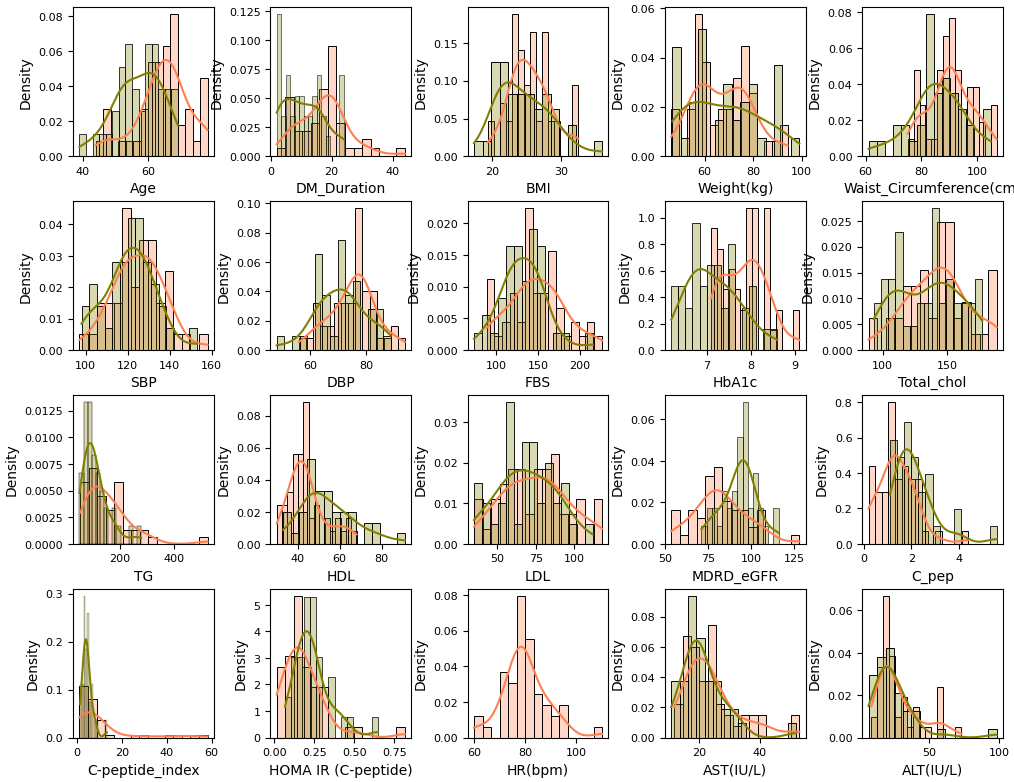

In [11]:
plt.figure(figsize=(12,12))

for i, var in enumerate(continuous_var):
    ax = plt.subplot(5,5,i+1)
    ax = sns.histplot(data = metadata_filt,x=var,bins=15,stat='density',color='coral',alpha=0.3,kde=True)
    ax = sns.histplot(data = evaluation_clinical_data,x=var,bins=15,stat='density',color='olive',alpha=0.3,kde=True)
    ax.tick_params(axis="both", labelsize=8) 

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

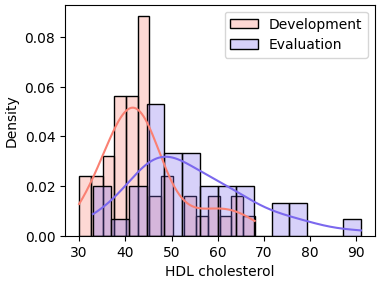

In [11]:
plt.figure(figsize=(4,3))
sns.histplot(data = metadata_filt,x='HDL',bins=15,stat='density',color='salmon',alpha=0.3,kde=True,label='Development')
sns.histplot(data = evaluation_clinical_data,x='HDL',bins=15,stat='density',color='mediumslateblue',alpha=0.3,kde=True,label='Evaluation')
plt.xlabel('HDL cholesterol')
plt.legend()
plt.show()

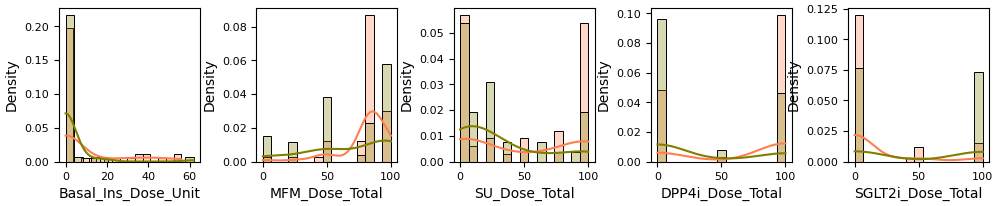

In [14]:
plt.figure(figsize=(12,2))

for i, var in enumerate(med_col):
    ax = plt.subplot(1,5,i+1)
    ax = sns.histplot(data = med_data,x=var,bins=15,stat='density',color='coral',alpha=0.3,kde=True)
    ax = sns.histplot(data = evaluation_clinical_data,x=var,bins=15,stat='density',color='olive',alpha=0.3,kde=True)
    ax.tick_params(axis="both", labelsize=8) 

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

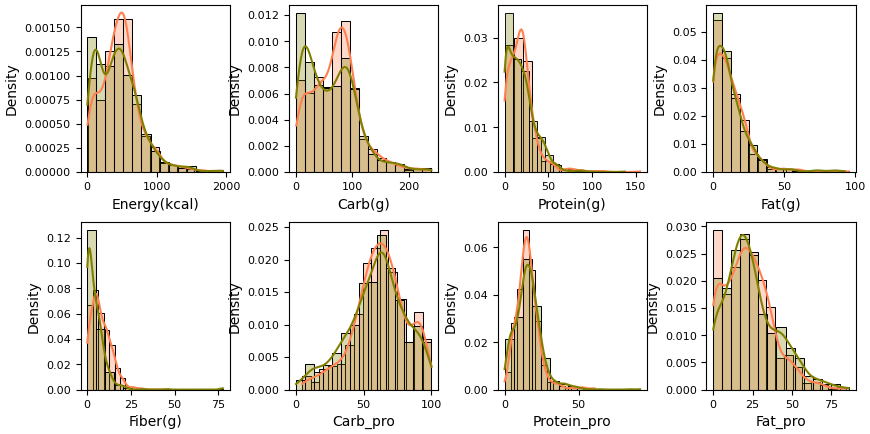

In [15]:
plt.figure(figsize=(10,5))

for i, var in enumerate(macronutrient_var):
    ax = plt.subplot(2,4,i+1)
    ax = sns.histplot(data = full_data,x=var,bins=15,stat='density',color='coral',alpha=0.3,kde=True)
    ax = sns.histplot(data = evaluation_data,x=var,bins=15,stat='density',color='olive',alpha=0.3,kde=True)
    ax.tick_params(axis="both", labelsize=8) 

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

### Categorical variables

In [16]:
category_var = ['Sex','Insulin_use(Basal)','OAD_number','BP_med','Dyslipidemia_med','HTN','Dyslipidemia']
for var in category_var:
    print(metadata_filt[var].value_counts())
    print(len(metadata_filt[metadata_filt[var]==1])/len(metadata_filt))
    pivot = pd.DataFrame({'main':metadata_filt[var].value_counts(),'eval':evaluation_clinical_data[var].value_counts()})
    res = stats.chi2_contingency(pivot)
    print(res)
    print()

Sex
2    25
1    24
Name: count, dtype: int64
0.4897959183673469
Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[25.05681818, 19.94318182],
       [23.94318182, 19.05681818]]))

Insulin_use(Basal)
0    36
1    13
Name: count, dtype: int64
0.2653061224489796
Chi2ContingencyResult(statistic=2.719801680152017, pvalue=0.0991103289000328, dof=1, expected_freq=array([[39.53409091, 31.46590909],
       [ 9.46590909,  7.53409091]]))

OAD_number
3    36
2     7
4     4
1     2
Name: count, dtype: int64
0.04081632653061224
Chi2ContingencyResult(statistic=nan, pvalue=nan, dof=4, expected_freq=array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]]))

BP_med
1    28
0    21
Name: count, dtype: int64
0.5714285714285714
Chi2ContingencyResult(statistic=2.3314692444260574, pvalue=0.12678216318861776, dof=1, expected_freq=array([[25.05681818, 19.94318182],
       [23.94318182, 19.05681818]]))

Dyslipidemia_med
1    42
0     7
Name: co

# Correlation analysis
## Clinical variables vs per gram of carbohydrate

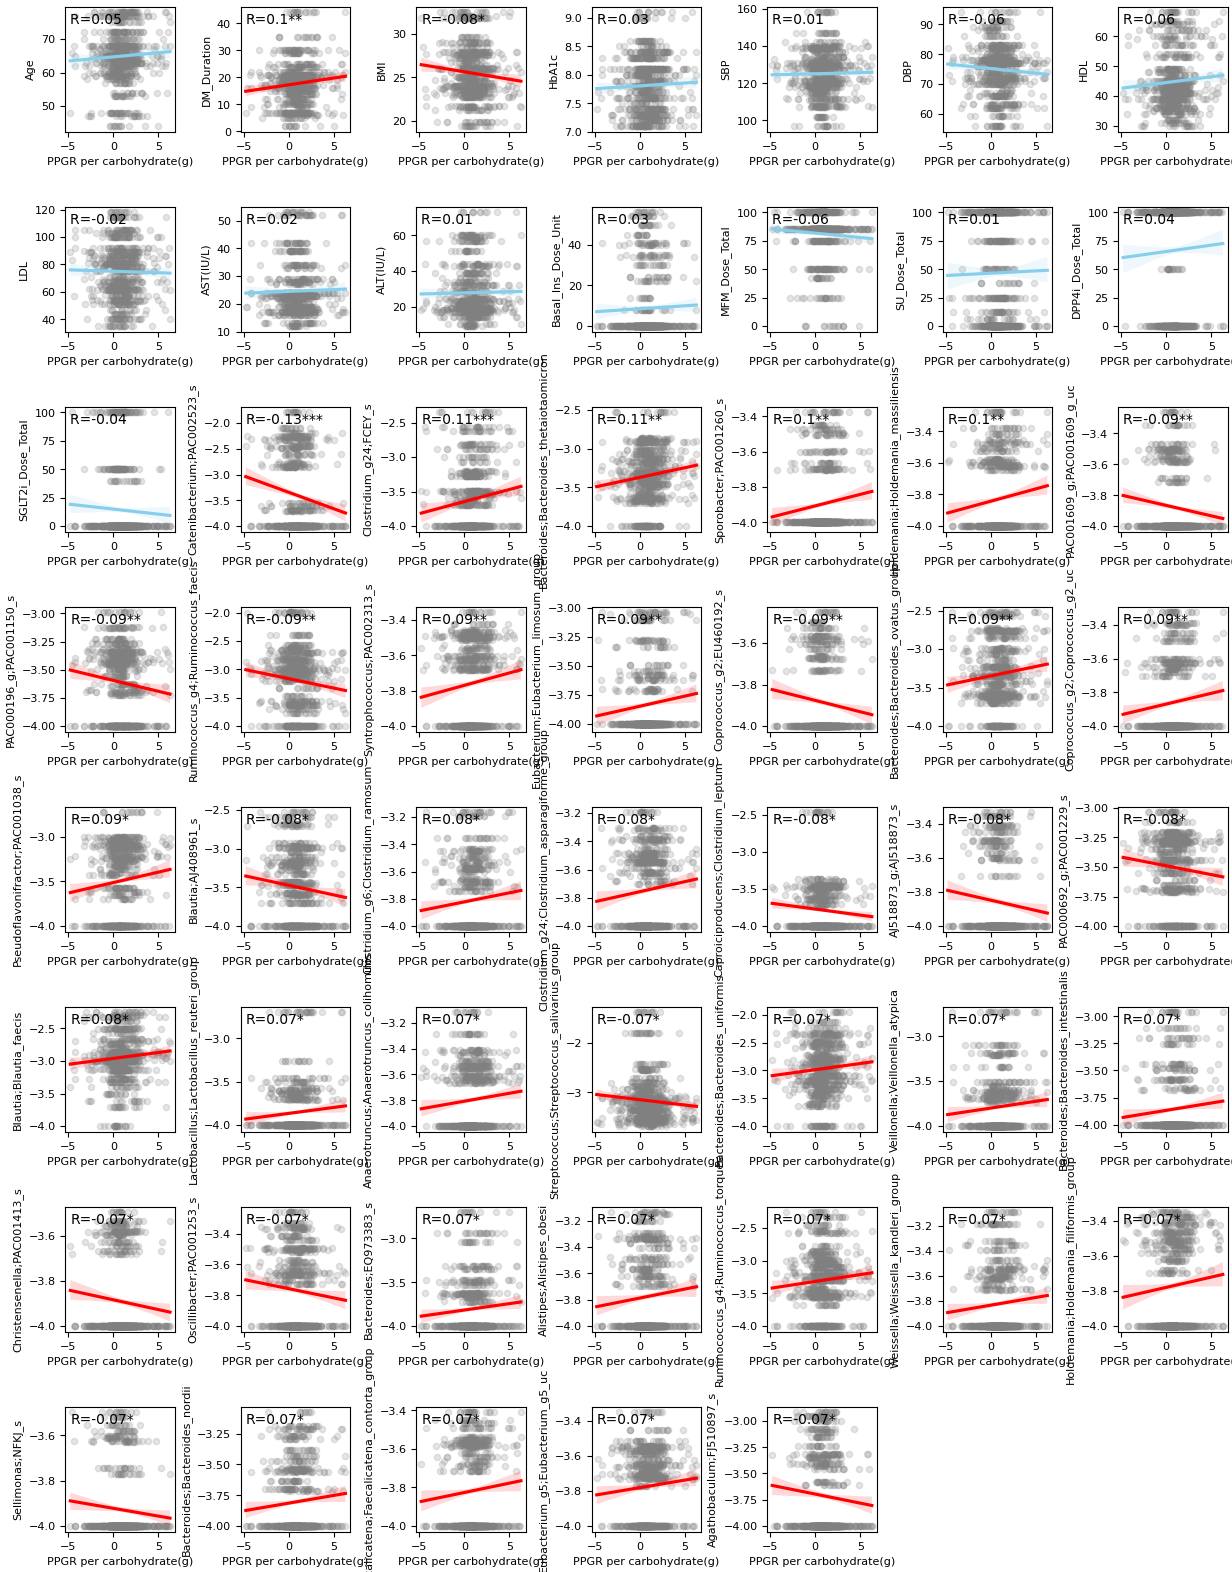

In [27]:
cont_R_list_main = []
cont_P_list_main = []
source = ['clinical']*len(cli_col) + ['medication']*len(med_col) + ['microbiome']*len(microbiome_col_)

X_main = full_data[PPGR]/full_data['Carb(g)'].astype(float)
q1_main = X_main.quantile(0.25)
q3_main = X_main.quantile(0.75)
IQR_main = q3_main-q1_main
dff_main = X_main[(X_main<=q3_main + (3*IQR_main)) & (X_main>=q1_main-(3*IQR_main))]
X_main = dff_main

plt.figure(figsize=(15,25))
for i, var in enumerate(cli_col+med_col+microbiome_col_):
    r_main,p_main = stats.pearsonr(X_main,full_data[var][dff_main.index].astype(float))
    cont_R_list_main.append(r_main)
    ax = plt.subplot(10,7,i+1)

    if 0.01<p_main<=0.05:
        color='red'
        cont_P_list_main.append('*')
    elif 0.001<p_main<=0.01:
        color='red'
        cont_P_list_main.append('**')
    elif p_main<=0.001:
        color='red'
        cont_P_list_main.append('***')
    else:
        color='skyblue'
        cont_P_list_main.append(' ')

    sns.regplot(x=X_main,y=full_data[var][dff_main.index].astype(float),ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
        
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(X_main.min(),(full_data[var].max()-full_data[var].min())*0.9+full_data[var].min(),f'R={np.round(r_main,2)}{cont_P_list_main[i]}')
    ax.set_xlabel('PPGR per carbohydrate(g)',fontsize=8)
    ax.set_ylabel(var,fontsize=8)

plt.subplots_adjust(wspace=0.6,hspace=0.6)
#plt.savefig('../figure/clinical_4hPPGR_corr.jpeg',dpi=300)
plt.show()

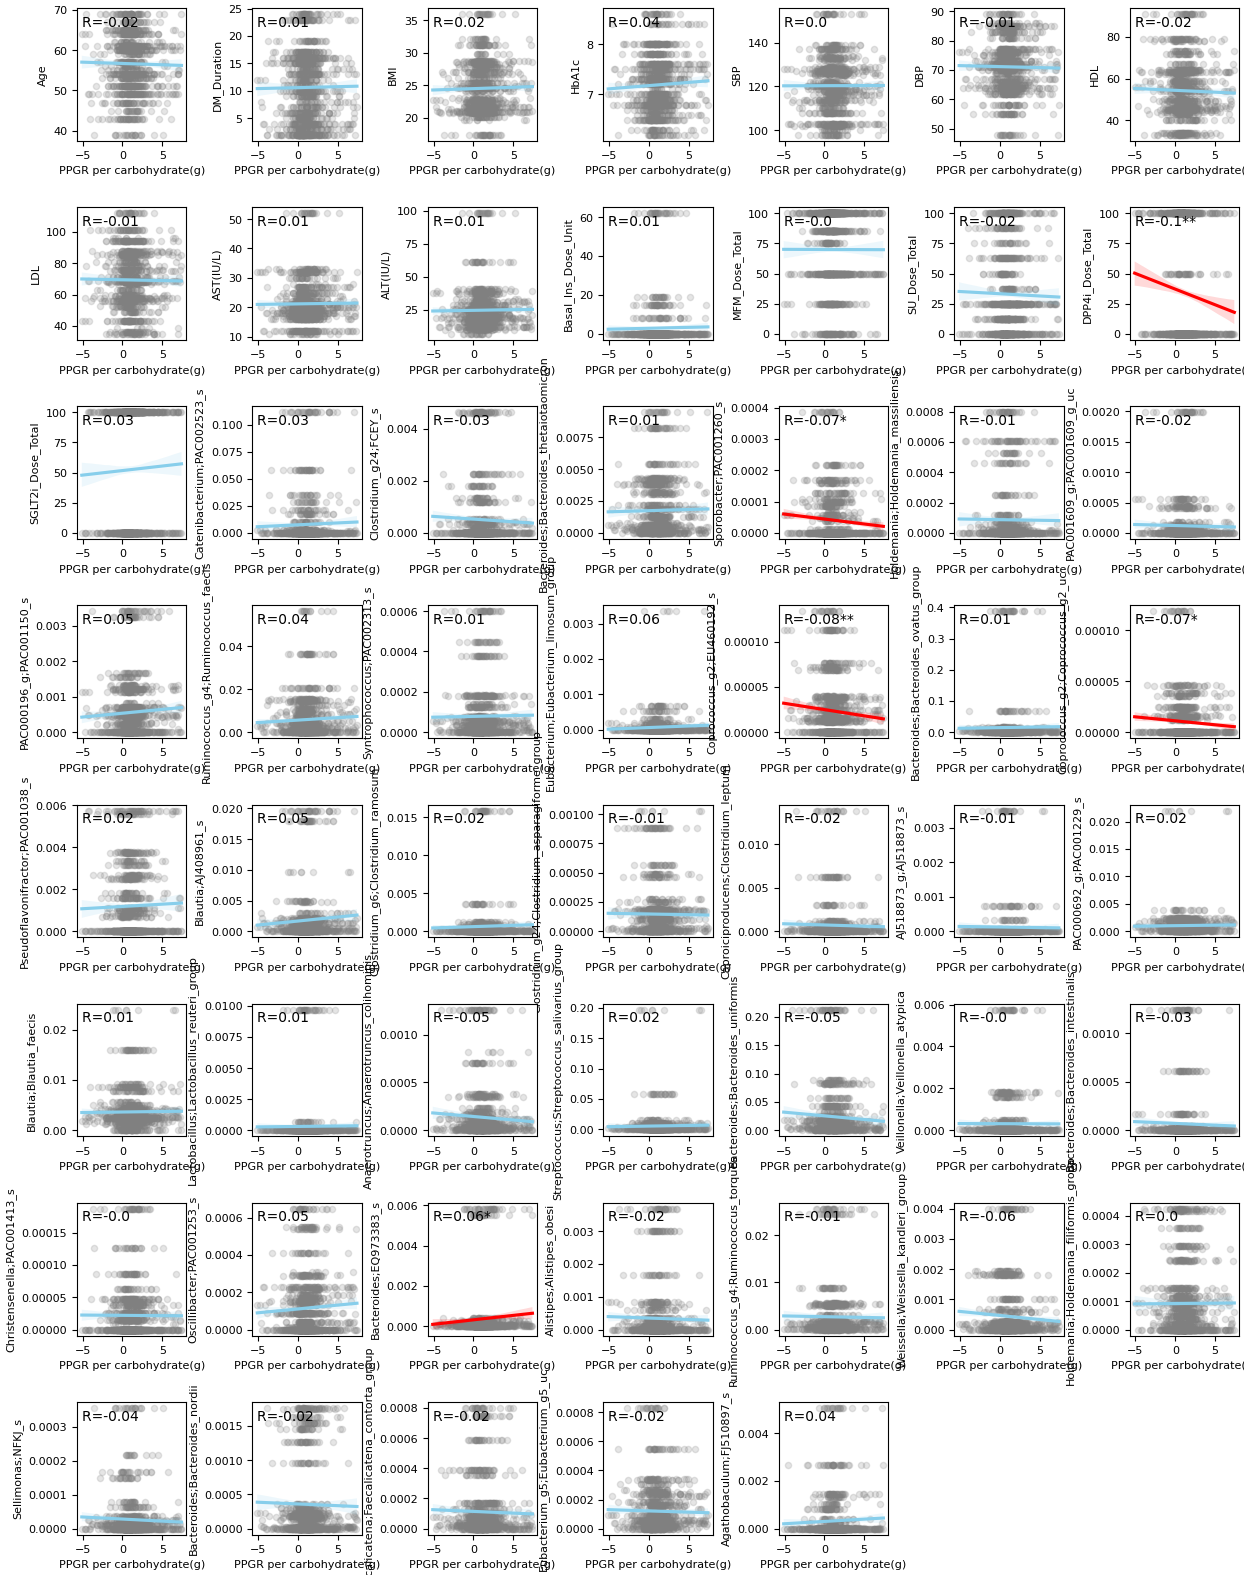

In [29]:
cont_R_list_eval = []
cont_P_list_eval = []
source = ['clinical']*len(cli_col) + ['medication']*len(med_col) + ['microbiome']*len(microbiome_col_)

X_eval = evaluation_data[PPGR]/evaluation_data['Carb(g)'].astype(float)
q1_eval = X_eval.quantile(0.25)
q3_eval = X_eval.quantile(0.75)
IQR_eval = q3_eval-q1_eval
dff_eval = X_eval[(X_eval<=q3_eval + (3*IQR_eval)) & (X_eval>=q1_eval-(3*IQR_eval))]
X_eval = dff_eval

plt.figure(figsize=(15,25))
for i, var in enumerate(cli_col+med_col+microbiome_col_):
    r_eval,p_eval = stats.pearsonr(X_eval,evaluation_data[var][dff_eval.index].astype(float))
    cont_R_list_eval.append(r_eval)
    ax = plt.subplot(10,7,i+1)

    if 0.01<p_eval<=0.05:
        color='red'
        cont_P_list_eval.append('*')
    elif 0.001<p_eval<=0.01:
        color='red'
        cont_P_list_eval.append('**')
    elif p_eval<=0.001:
        color='red'
        cont_P_list_eval.append('***')
    else:
        color='skyblue'
        cont_P_list_eval.append(' ')

    sns.regplot(x=X_eval,y=evaluation_data[var][dff_eval.index].astype(float),ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
        
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(X_eval.min(),(evaluation_data[var].max()-evaluation_data[var].min())*0.9+evaluation_data[var].min(),f'R={np.round(r_eval,2)}{cont_P_list_eval[i]}')
    ax.set_xlabel('PPGR per carbohydrate(g)',fontsize=8)
    ax.set_ylabel(var,fontsize=8)

plt.subplots_adjust(wspace=0.6,hspace=0.5)
#plt.savefig('../figure/clinical_4hPPGR_corr.jpeg',dpi=300)
plt.show()

In [135]:
cont_var_df[cont_var_df['target']=='Carbohydrate']

variable         R       p value  \
0                                                Age -0.128483  1.007485e-04   
5                                        DM_Duration -0.067142  4.276259e-02   
10                                               BMI  0.110128  8.698610e-04   
15                                             HbA1c  0.011198  7.357093e-01   
20                                               SBP  0.025605  4.401677e-01   
25                                               DBP  0.148019  7.249438e-06   
30                                               HDL -0.088406  7.587527e-03   
35                                               LDL  0.008518  7.973806e-01   
40                                         AST(IU/L)  0.052510  1.132373e-01   
45                                         ALT(IU/L)  0.095748  3.820400e-03   
50                       Catenibacterium;PAC002523_s  0.110874  8.015884e-04   
55                            Clostridium_g24;FCEY_s -0.082879  1.233602e-02   
60          Bacteroides;Bacteroides_thetaiotaomicron -0.085332  9.973909e-03   
65                           Sporobacter;PAC001260_s -0.151811  4.174513e-06   
70                Holdemania;Holdemania_massiliensis -0.094271  4.402475e-03   
75                        PAC001609_g;PAC001609_g_uc -0.042880  1.959922e-01   
80                           PAC000196_g;PAC001150_s  0.039325  2.357198e-01   
85               Ruminococcus_g4;Ruminococcus_faecis -0.113164  6.218083e-04   
90                       Syntrophococcus;PAC002313_s -0.054945  9.744339e-02   
95             Eubacterium;Eubacterium_limosum_group -0.108626  1.024008e-03   
100                        Coprococcus_g2;EU460192_s  0.093186  4.879502e-03   
105             Bacteroides;Bacteroides_ovatus_group -0.138052  2.901012e-05   
110                 Coprococcus_g2;Coprococcus_g2_uc -0.093534  4.721543e-03   
115                 Pseudoflavonifractor;PAC001038_s -0.021737  5.123047e-01   
120                               Blautia;AJ408961_s  0.080653  1.489319e-02   
125               Clostridium_g6;Clostridium_ramosum -0.006220  8.512807e-01   
130  Clostridium_g24;Clostridium_asparagiforme_group -0.046244  1.631403e-01   
135             Caproiciproducens;Clostridium_leptum  0.058287  7.868692e-02   
140                            AJ518873_g;AJ518873_s -0.020771  5.312361e-01   
145                          PAC000692_g;PAC001229_s -0.047813  1.493136e-01   
150                           Blautia;Blautia_faecis  0.009603  7.722389e-01   
155        Lactobacillus;Lactobacillus_reuteri_group -0.197176  1.946870e-09   
160          Anaerotruncus;Anaerotruncus_colihominis -0.129846  8.480677e-05   
165     Streptococcus;Streptococcus_salivarius_group  0.181729  3.320816e-08   
170                Bacteroides;Bacteroides_uniformis -0.097209  3.314318e-03   
175                  Veillonella;Veillonella_atypica -0.145661  1.014873e-05   
180             Bacteroides;Bacteroides_intestinalis -0.076038  2.172109e-02   
185                      Christensenella;PAC001413_s  0.025042  4.502956e-01   
190                        Oscillibacter;PAC001253_s  0.026985  4.159211e-01   
195                           Bacteroides;EQ973383_s -0.111241  7.698688e-04   
200                        Alistipes;Alistipes_obesi  0.015703  6.359746e-01   
205             Ruminococcus_g4;Ruminococcus_torques  0.020152  5.435457e-01   
210               Weissella;Weissella_kandleri_group -0.047880  1.487433e-01   
215           Holdemania;Holdemania_filiformis_group -0.138402  2.767427e-05   
220                                Sellimonas;NFKJ_s -0.025766  4.373134e-01   
225                   Bacteroides;Bacteroides_nordii -0.099030  2.769177e-03   
230       Faecalicatena;Faecalicatena_contorta_group -0.012717  7.014810e-01   
235                 Eubacterium_g5;Eubacterium_g5_uc -0.013151  6.918044e-01   
240                         Agathobaculum;FJ510897_s -0.013708  6.794539e-01   

           target      source  -log10(p)  


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


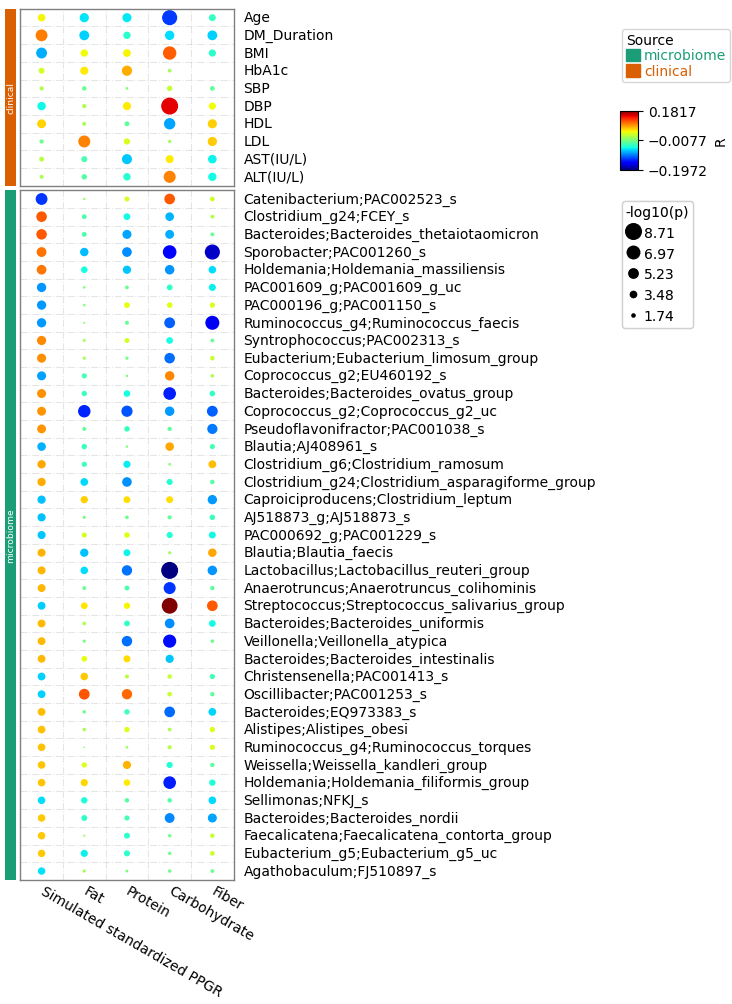

In [133]:
carb_r_list,carb_p_list=[],[]
fat_r_list,fat_p_list=[],[]
fiber_r_list,fiber_p_list=[],[]
protein_r_list,protein_p_list=[],[]
simul_PPGR_r_list, simul_PPGR_p_list = [],[]
source = ['clinical']*len(cli_col) + ['microbiome']*len(microbiome_col_)
## simulated PPGR#
X_main = full_data[PPGR]/full_data['Carb(g)'].astype(float)
q1_main = X_main.quantile(0.25)
q3_main = X_main.quantile(0.75)
IQR_main = q3_main-q1_main
dff_main = X_main[(X_main<=q3_main + (3*IQR_main)) & (X_main>=q1_main-(3*IQR_main))]
X_main = dff_main

# 결과를 저장할 리스트 초기화
results = []  
for i, var in enumerate(cli_col+microbiome_col_):
    carb_r,carb_p = stats.pearsonr(full_data['Carb(g)'],full_data[var].astype(float))
    fat_r,fat_p = stats.pearsonr(full_data['Fat(g)'],full_data[var].astype(float))
    fiber_r,fiber_p = stats.pearsonr(full_data['Fiber(g)'],full_data[var].astype(float))
    protein_r,protein_p = stats.pearsonr(full_data['Protein(g)'],full_data[var].astype(float))
    simul_r,simul_p = stats.pearsonr(X_main,full_data[var][dff_main.index].astype(float))

    # 결과를 리스트에 추가
    results.append({'variable': var, 'R': carb_r, 'p value': carb_p, 'target': 'Carbohydrate', 'source': source[i]})
    results.append({'variable': var, 'R': fat_r, 'p value': fat_p, 'target': 'Fat', 'source': source[i]})
    results.append({'variable': var, 'R': fiber_r, 'p value': fiber_p, 'target': 'Fiber', 'source': source[i]})
    results.append({'variable': var, 'R': protein_r, 'p value': protein_p, 'target': 'Protein', 'source': source[i]})
    results.append({'variable': var, 'R': simul_r, 'p value': simul_p, 'target': 'Simulated standardized PPGR', 'source': source[i]})

cont_var_df = pd.DataFrame(results)
#cont_var_df['-log10(p)'] = np.where(-np.log10(cont_var_df['p value'])>-np.log10(0.05),-np.log10(cont_var_df['p value']),0)
cont_var_df['-log10(p)'] = -np.log10(cont_var_df['p value'])
plt.figure(figsize=(3,10))

left_ha  = HeatmapAnnotation(Source=anno_simple(cont_var_df.drop_duplicates('variable').set_index('variable')['source'],legend=True,cmap='Dark2',add_text=True),
                           axis=0,label_kws={'visible':False,'fontsize':10})
cm = DotClustermapPlotter(data=cont_var_df, y='variable',x='target',value='R',c='R',s='-log10(p)',show_rownames=True,show_colnames=True,col_names_side='bottom',
                          row_dendrogram=False,row_cluster=False, row_split=cont_var_df.drop_duplicates('variable').set_index('variable')['source'], row_split_gap=1,
                          xticklabels_kws={'labelrotation': -30, 'labelsize':10},left_annotation=left_ha,legend_hpad=-2)

for ax in cm.heatmap_axes.ravel():
    ax.grid(axis='both',which='minor',color='black',linestyle='dashdot',alpha=0.1) # which can also be set to major
    for side in ["top", "left", "bottom",'right']: # to show the spines
         ax.spines[side].set_visible(True)
         ax.spines[side].set_color('grey')
         ax.spines[side].set_linewidth(1)
         ax.spines[side].set_linestyle('-')

plt.savefig('../figure/personal_variable_PPGR2h_corr_dot.jpeg',dpi=300,bbox_inches='tight')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


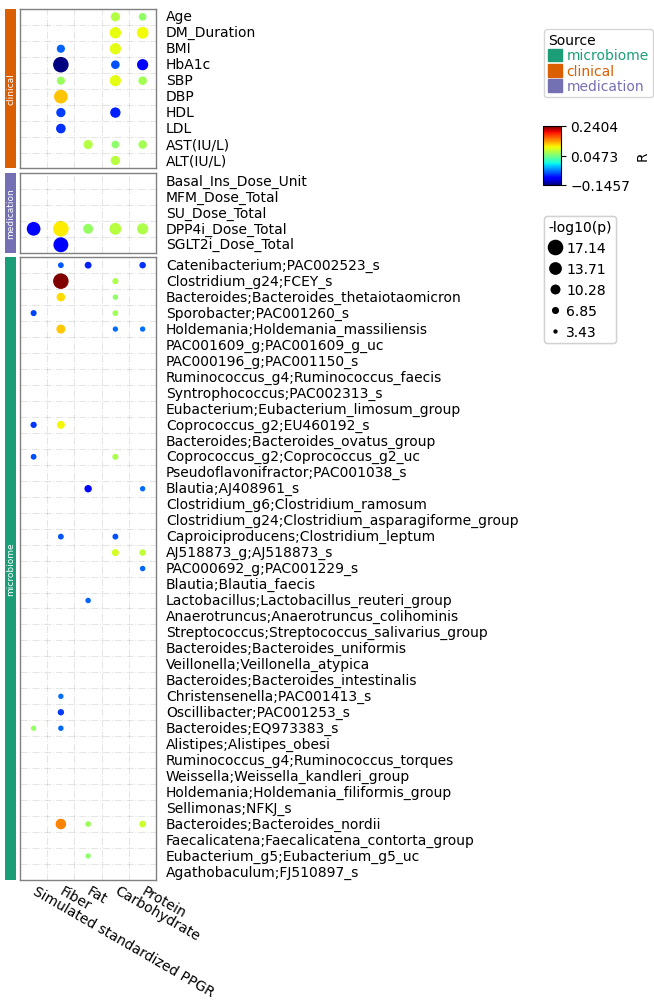

In [119]:
carb_r_list,carb_p_list=[],[]
fat_r_list,fat_p_list=[],[]
fiber_r_list,fiber_p_list=[],[]
protein_r_list,protein_p_list=[],[]
simul_PPGR_r_list, simul_PPGR_p_list = [],[]

## simulated PPGR#
X_eval = evaluation_data[PPGR]/evaluation_data['Carb(g)'].astype(float)
q1_eval = X_eval.quantile(0.25)
q3_eval = X_eval.quantile(0.75)
IQR_eval = q3_eval-q1_eval
dff_eval = X_eval[(X_eval<=q3_eval + (3*IQR_eval)) & (X_eval>=q1_eval-(3*IQR_eval))]
X_eval = dff_eval

# 결과를 저장할 리스트 초기화
results = []  
for i, var in enumerate(cli_col+med_col+microbiome_col_):
    carb_r,carb_p = stats.pearsonr(evaluation_data['Carb(g)'],evaluation_data[var].astype(float))
    fat_r,fat_p = stats.pearsonr(evaluation_data['Fat(g)'],evaluation_data[var].astype(float))
    fiber_r,fiber_p = stats.pearsonr(evaluation_data['Fiber(g)'],evaluation_data[var].astype(float))
    protein_r,protein_p = stats.pearsonr(evaluation_data['Protein(g)'],evaluation_data[var].astype(float))
    simul_r,simul_p = stats.pearsonr(X_eval,evaluation_data[var][dff_eval.index].astype(float))

    # 결과를 리스트에 추가
    results.append({'variable': var, 'R': carb_r, 'p value': carb_p, 'target': 'Carbohydrate', 'source': source[i]})
    results.append({'variable': var, 'R': fat_r, 'p value': fat_p, 'target': 'Fat', 'source': source[i]})
    results.append({'variable': var, 'R': fiber_r, 'p value': fiber_p, 'target': 'Fiber', 'source': source[i]})
    results.append({'variable': var, 'R': protein_r, 'p value': protein_p, 'target': 'Protein', 'source': source[i]})
    results.append({'variable': var, 'R': simul_r, 'p value': simul_p, 'target': 'Simulated standardized PPGR', 'source': source[i]})

cont_var_df = pd.DataFrame(results)
cont_var_df['-log10(p)'] = np.where(-np.log10(cont_var_df['p value'])>-np.log10(0.05),-np.log10(cont_var_df['p value']),0)

plt.figure(figsize=(2,10))

left_ha  = HeatmapAnnotation(Source=anno_simple(cont_var_df.drop_duplicates('variable').set_index('variable')['source'],legend=True,cmap='Dark2',add_text=True),
                           axis=0,label_kws={'visible':False})
cm = DotClustermapPlotter(data=cont_var_df, y='variable',x='target',value='R',c='R',s='-log10(p)',show_rownames=True,show_colnames=True,col_names_side='bottom',
                          row_dendrogram=False,row_cluster=False, row_split=cont_var_df.drop_duplicates('variable').set_index('variable')['source'], row_split_gap=1,
                          xticklabels_kws={'labelrotation': -30, 'labelsize':10},left_annotation=left_ha,legend_hpad=-2)

for ax in cm.heatmap_axes.ravel():
    ax.grid(axis='both',which='minor',color='black',linestyle='dashdot',alpha=0.1) # which can also be set to major
    for side in ["top", "left", "bottom",'right']: # to show the spines
         ax.spines[side].set_visible(True)
         ax.spines[side].set_color('grey')
         ax.spines[side].set_linewidth(1)
         ax.spines[side].set_linestyle('-')

plt.savefig('../figure/personal_variable_PPGR2h_corr_dot_eval.jpeg',dpi=300,bbox_inches='tight')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


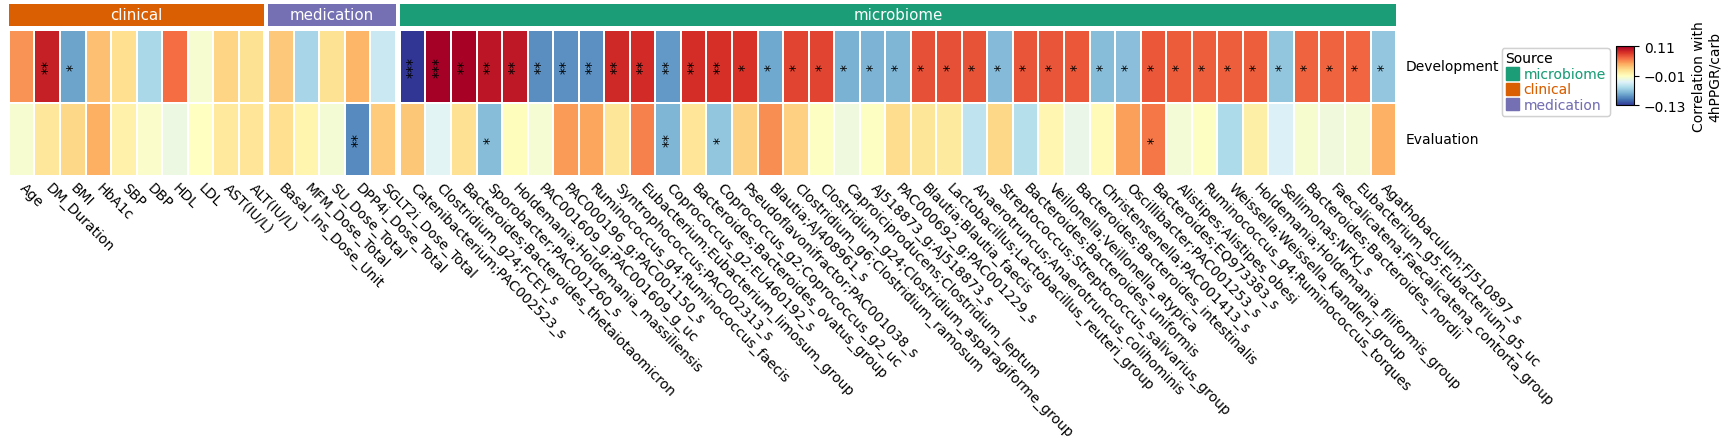

In [30]:
import sys
sys.executable
cont_var_df = pd.DataFrame({'Development':cont_R_list_main,'Evaluation':cont_R_list_eval,'Main_p':cont_P_list_main,'Eval_p':cont_P_list_eval,'source':source},index=cli_col+med_col+microbiome_col_)
heatmap_df = cont_var_df[['Development','Evaluation']]
row_ha = HeatmapAnnotation(Source=anno_simple(cont_var_df['source'],legend=True,cmap='Dark2',add_text=True,height=5),
                           axis=1,label_kws={'visible':False})

annot_map = cont_var_df[['Main_p','Eval_p']].rename(columns={'Main_p':'Development','Eval_p':'Evaluation'})

plt.figure(figsize=(18,2))
cm = ClusterMapPlotter(data = heatmap_df.T, cmap='RdYlBu_r',annot=annot_map.T,annot_kws={'color':'black','rotation':90},fmt=None,
                       top_annotation=row_ha,label='Correlation with\n4hPPGR/carb',col_split=cont_var_df['source'],col_split_gap=1,
                       show_rownames=True,show_colnames=True,row_cluster=False,row_dendrogram=False,col_cluster=False,
                       xticklabels_kws=dict(labelrotation=-45),linewidths=0.05,linecolor='white')#
plt.savefig('../figure/personal_variable_PPGR2h_corr_heatmap.jpeg',dpi=300,bbox_inches='tight')
plt.show()

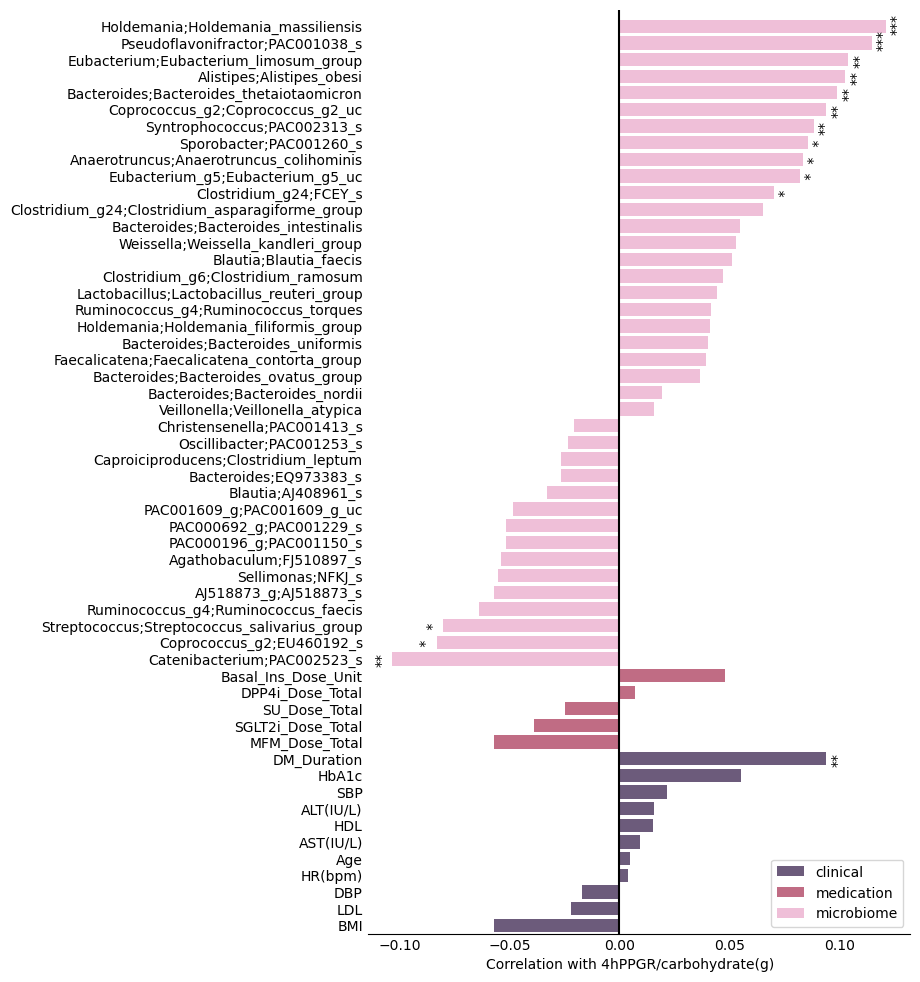

In [11]:
cont_var_df = pd.DataFrame({'var':continuous_var+med_col+microbiome_col,'Pearson correlation with PPGR':cont_R_list,'source':source,'p-value':cont_P_list})
cont_var_df=cont_var_df[cont_var_df['var'].isin(cli_col+med_col+microbiome_col)]
cont_var_df_sorted = cont_var_df.sort_values(by=['source','Pearson correlation with PPGR'])

COLORS = {'clinical':"#6C5B7B",'medication':"#C06C84",'microbiome':'#EFBFD8'}
c = cont_var_df_sorted['source'].apply(lambda x: COLORS[x])

plt.figure(figsize=(7,12))
plt.barh(data=cont_var_df_sorted,y='var',width='Pearson correlation with PPGR',color=c)
plt.axvline(x=0,color='black')
for i,p in enumerate(cont_var_df_sorted['p-value']):
    pad=0.002
    if list(cont_var_df_sorted['Pearson correlation with PPGR'])[i]<0:
        pad = -0.008
    plt.text(x=cont_var_df_sorted.iloc[i,1]+pad,y=i-0.3,s=p,rotation=90)
ax = plt.gca()
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(axis='both', length=0)
plt.xlabel('Correlation with 4hPPGR/carbohydrate(g)    ')

for i, j in COLORS.items(): #Loop over color dictionary
    plt.barh(data=cont_var_df_sorted,y='var',width=0,color=j,label=i) #Plot invisible bar graph but have the legends specified
plt.yticks(cont_var_df['var'],[';'.join(var.split(';')[-2:]) for var in cont_var_df['var']])
plt.legend(loc='lower right')
plt.ylim(-0.5,len(microbiome_col)+len(cli_col)+len(med_col))
plt.savefig('../figure/personal_variable_PPGR4h_corr.jpeg',dpi=300,bbox_inches='tight')
plt.show()

## Meal variables

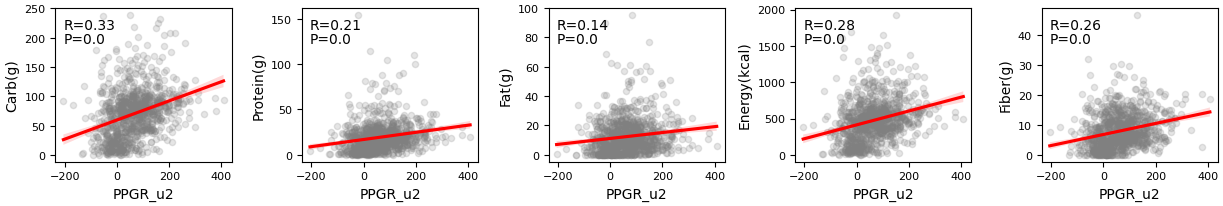

In [18]:
#full_data = full_data.rename(columns={'Meal':'Meal_type'})
data = full_data

meal_R_list = []
meal_P_list = []
plt.figure(figsize=(15,2))
var_list =['Carb(g)','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)']
data[var_list] = data[var_list].astype(float)
for i, var in enumerate(var_list):
    r,p = stats.pearsonr(data[PPGR],data[var])
    meal_R_list.append(r)
    ax = plt.subplot(1,5,i+1)

    if 0.01<p<=0.05:
        color='red'
        meal_P_list.append(' * ')
    elif 0.001<p<=0.01:
        color='red'
        meal_P_list.append(' **')
    elif p<=0.001:
        color='red'
        meal_P_list.append('***')
    else:
        color='skyblue'
        meal_P_list.append('')
    sns.regplot(data = data,x=PPGR,y=var,ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.9+data[var].min(),f'R={np.round(r,2)}')
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.8+data[var].min(),f'P={np.round(p,2)}')

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

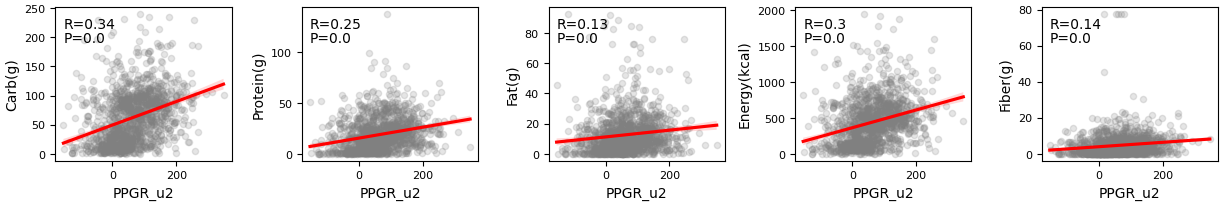

In [19]:
data = evaluation_data

meal_R_list_eval = []
meal_P_list_eval = []
plt.figure(figsize=(15,2))
var_list =['Carb(g)','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)']
data[var_list] = data[var_list].astype(float)
for i, var in enumerate(var_list):
    r,p = stats.pearsonr(data[PPGR],data[var])
    meal_R_list_eval.append(r)
    ax = plt.subplot(1,5,i+1)

    if 0.01<p<=0.05:
        color='red'
        meal_P_list_eval.append(' * ')
    elif 0.001<p<=0.01:
        color='red'
        meal_P_list_eval.append(' **')
    elif p<=0.001:
        color='red'
        meal_P_list_eval.append('***')
    else:
        color='skyblue'
        meal_P_list_eval.append('')
    sns.regplot(data = data,x=PPGR,y=var,ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.9+data[var].min(),f'R={np.round(r,2)}')
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.8+data[var].min(),f'P={np.round(p,2)}')

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

In [60]:
meal_var_df_2h

var      Main  Evaluation Main_p Evaluation_p
2        Fat(g)  0.131531    0.139402    ***          ***
1    Protein(g)  0.178353    0.240730    ***          ***
4      Fiber(g)  0.189498    0.106149    ***          ***
3  Energy(kcal)  0.273537    0.292561    ***          ***
0       Carb(g)  0.334589    0.320403    ***          ***

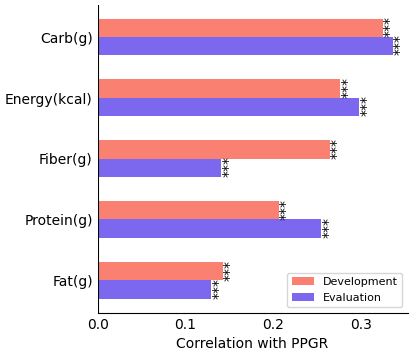

In [21]:
meal_var_df_2h = pd.DataFrame({'var':var_list,'Development':meal_R_list,'Evaluation':meal_R_list_eval,'Main_p':meal_P_list,'Evaluation_p':meal_P_list_eval}).sort_values('Development')
index = np.arange(len(meal_var_df_2h))
plt.figure(figsize=(4,4))
p1=plt.barh(data=meal_var_df_2h,y=index+0.15,width='Development',color="salmon",height=0.3,label='Development')
p2=plt.barh(data=meal_var_df_2h,y=index-0.15,width='Evaluation',color="mediumslateblue",height=0.3,label='Evaluation')
plt.axvline(x=0,color='black')
for i,p in enumerate(meal_var_df_2h['Main_p']):
    plt.text(x=meal_var_df_2h.iloc[i,1],y=i+0.05,s=p,rotation=90)
for i,p in enumerate(meal_var_df_2h['Evaluation_p']):
    plt.text(x=meal_var_df_2h.iloc[i,2],y=i-0.25,s=p,rotation=90)
ax = plt.gca()
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(axis='both', length=0)
plt.xlabel('Correlation with PPGR')
plt.yticks(index,meal_var_df_2h['var'])
plt.legend((p1[0], p2[0]), ('Development', 'Evaluation'),fontsize=8)
plt.savefig('../figure/meal_variable_PPGR2h_corr.jpeg',dpi=300,bbox_inches='tight')
plt.show()

## Microbiome variables

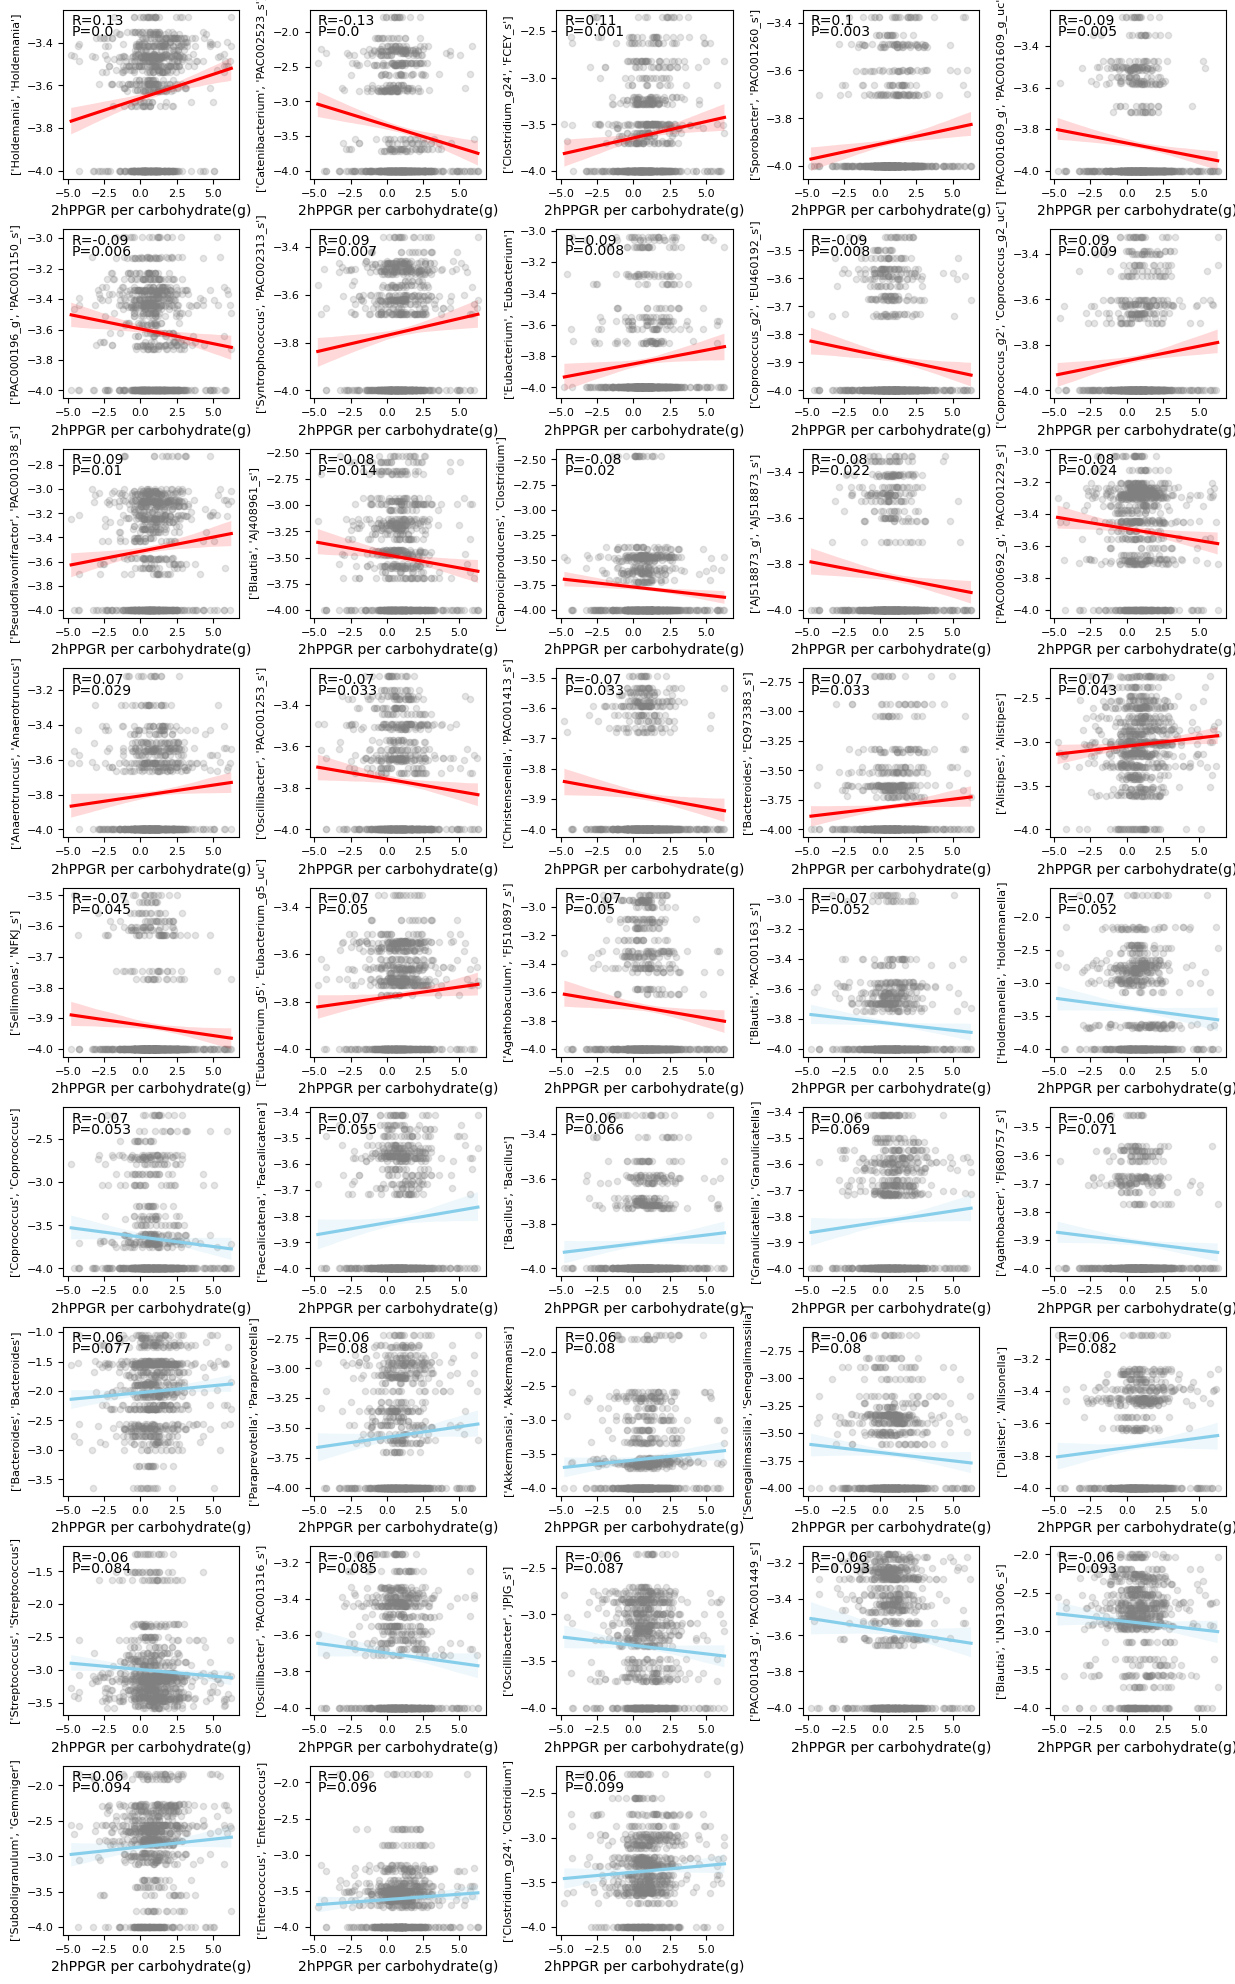

In [77]:
full_data = full_data.rename(columns={'Meal':'Meal_type'})
data = full_data
cont_R_list = []
cont_P_list = []
plt.figure(figsize=(15,25))

X = full_data[PPGR]/full_data['Carb(g)'].astype(float)
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
IQR = q3-q1
dff = X[(X<=q3 + (3*IQR)) & (X>=q1-(3*IQR))]
X = dff


for i, var in enumerate(microbiome_col):
    r,p = stats.pearsonr(X,full_data[var][dff.index])
    cont_R_list.append(r)
    ax = plt.subplot(9,5,i+1)

    if 0.01<p<=0.05:
        color='red'
        cont_P_list.append(' * ')
    elif 0.001<p<=0.01:
        color='red'
        cont_P_list.append(' **')
    elif p<=0.001:
        color='red'
        cont_P_list.append('***')
    else:
        color='skyblue'
        cont_P_list.append('')
    sns.regplot(x = X,y=full_data[var][dff.index].astype(float),ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(X.min(),(full_data[var].max()-full_data[var].min())*0.95+full_data[var].min(),f'R={np.round(r,2)}')
    ax.text(X.min(),(full_data[var].max()-full_data[var].min())*0.88+full_data[var].min(),f'P={np.round(p,3)}')
    ax.set_xlabel('2hPPGR per carbohydrate(g)')
    ax.set_ylabel(var.split(';')[-2:],fontsize=8)
plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

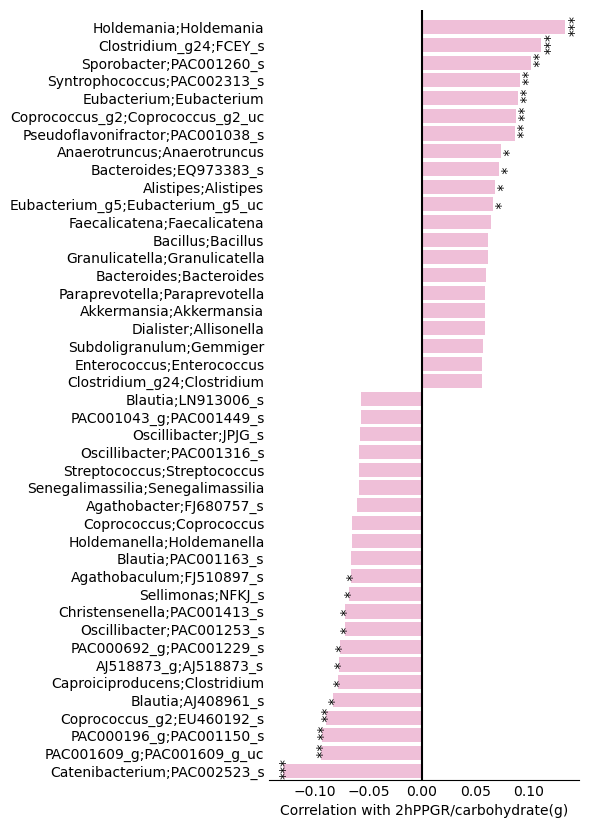

In [78]:
cont_var_df = pd.DataFrame({'var':microbiome_col,'Pearson correlation with PPGR':cont_R_list,'p-value':cont_P_list}).sort_values('Pearson correlation with PPGR')

plt.figure(figsize=(4,10))
plt.barh(data=cont_var_df,y='var',width='Pearson correlation with PPGR',color='#EFBFD8')
plt.axvline(x=0,color='black')
for i,p in enumerate(cont_var_df['p-value']):
    pad=0.002
    text=''
    if list(cont_var_df['Pearson correlation with PPGR'])[i]<0:
        pad = -0.005
    plt.text(x=cont_var_df.iloc[i,1]+pad,y=i-0.3,s=p,rotation=90)
ax = plt.gca()
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(axis='both', length=0)
plt.yticks(cont_var_df['var'],[';'.join(var.split(';')[-2:]) for var in cont_var_df['var']])
plt.xlabel('Correlation with 2hPPGR/carbohydrate(g)')
plt.ylim(-0.5,len(microbiome_col))
plt.savefig('../figure/microbiome_variable_PPGR2h_corr.jpeg',dpi=300,bbox_inches='tight')
plt.show()

# PPGR distribution

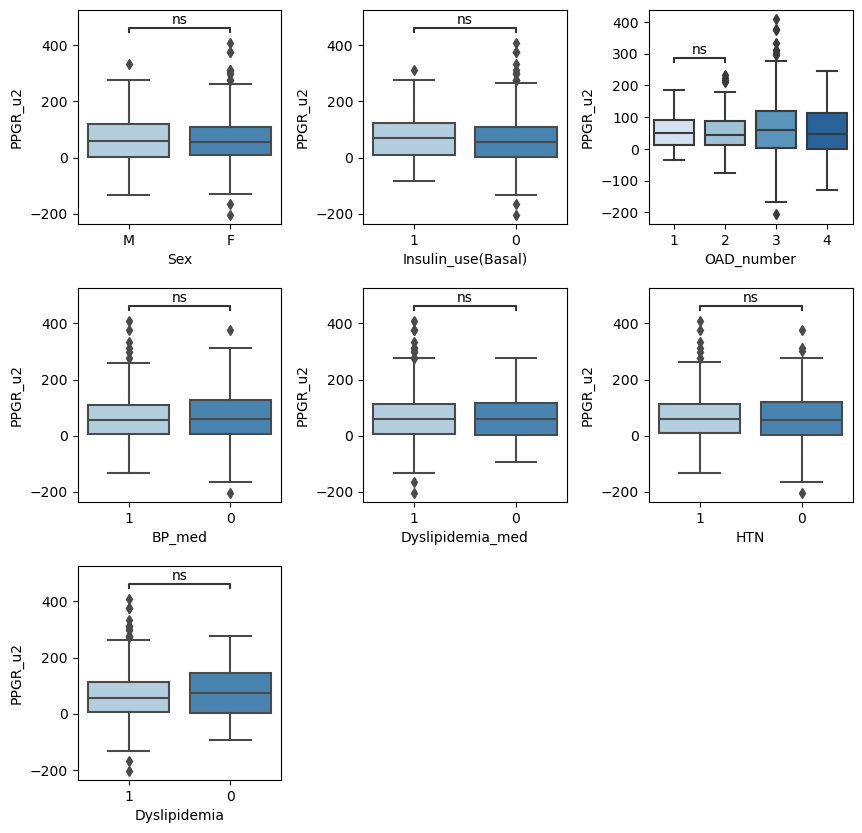

In [12]:
data[category_var] = data[category_var].astype(str)
plt.figure(figsize=(10,10))
ax = plt.subplot(3,3,1)
ax = sns.boxplot(x='Sex',y=PPGR,data=data, palette="Blues")
ax.set_xticks([0,1],['M','F'])
add_stat_annotation(ax, data=data, x=PPGR,y='Sex',test='t-test_ind',box_pairs=[('1','2')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

ax = plt.subplot(3,3,2)
ax = sns.boxplot(x='Insulin_use(Basal)',y=PPGR,data=data, palette="Blues")
add_stat_annotation(ax, data=data, x=PPGR,y='Insulin_use(Basal)',test='t-test_ind',box_pairs=[('0','1')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

ax = plt.subplot(3,3,3)
ax = sns.boxplot(x='OAD_number',y=PPGR,data=data, palette="Blues",order=['1','2','3','4'])
add_stat_annotation(ax, data=data, x=PPGR,y='OAD_number',test='t-test_ind',order=['1','2','3','4'],box_pairs=[('1','2')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

ax = plt.subplot(3,3,4)
ax = sns.boxplot(x='BP_med',y=PPGR,data=data, palette="Blues")
add_stat_annotation(ax, data=data, x=PPGR,y='BP_med',test='t-test_ind',box_pairs=[('0','1')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

ax = plt.subplot(3,3,5)
ax = sns.boxplot(x='Dyslipidemia_med',y=PPGR,data=data, palette="Blues")
add_stat_annotation(ax, data=data, x=PPGR,y='Dyslipidemia_med',test='t-test_ind',box_pairs=[('0','1')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

ax = plt.subplot(3,3,6)
ax = sns.boxplot(x='HTN',y=PPGR,data=data, palette="Blues")
add_stat_annotation(ax, data=data, x=PPGR,y='HTN',test='t-test_ind',box_pairs=[('0','1')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

ax = plt.subplot(3,3,7)
ax = sns.boxplot(x='Dyslipidemia',y=PPGR,data=data, palette="Blues")
add_stat_annotation(ax, data=data, x=PPGR,y='Dyslipidemia',test='t-test_ind',box_pairs=[('0','1')], 
                            text_format='star', loc='inside', verbose=0, show_test_name=False)

plt.subplots_adjust(wspace=0.4,hspace=0.3)

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2 v.s. 3: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-7.034e-01
1 v.s. 2: t-test independent samples with Bonferroni correction, P_val=4.144e-15 stat=8.343e+00
4 v.s. 5: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=2.974e-01
3 v.s. 4: t-test independent samples with Bonferroni correction, P_val=1.281e-07 stat=5.713e+00
1 v.s. 3: t-test independent samples with Bonferroni correction, P_val=1.544e-14 stat=8.144e+00


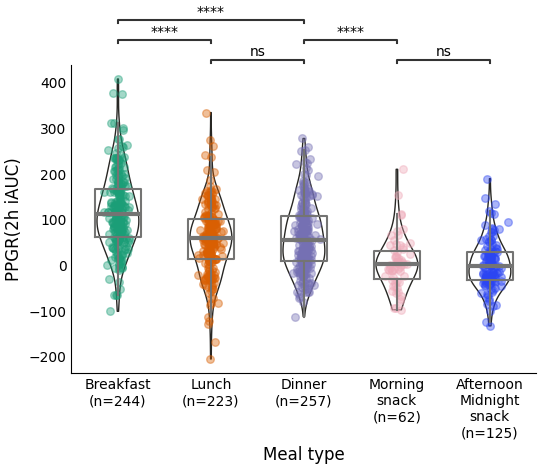

In [137]:
data = full_data
y_data = [data[data["Meal"] == type_][PPGR].values for type_ in [1,2,3,4,5]]

jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3",'#EEA9B8',"#2B45F2"]

fig, ax = plt.subplots(figsize= (6, 4))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("PPGR(2h iAUC)", size=12)

violins = ax.violinplot(
    y_data, 
    positions=[0,1,2,3,4],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1,2,3,4], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=data,x='Meal',y=PPGR,test='t-test_ind',box_pairs=[(2,3),(1,2),(1,3),(4,5),(3,4)], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['Breakfast','Lunch','Dinner','Morning\nsnack','Afternoon\nMidnight\nsnack'])]
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Meal type", size=12)
plt.savefig('../figure/meal_type_PPGR_2h_main.jpeg',dpi=300,bbox_inches='tight')
plt.show()

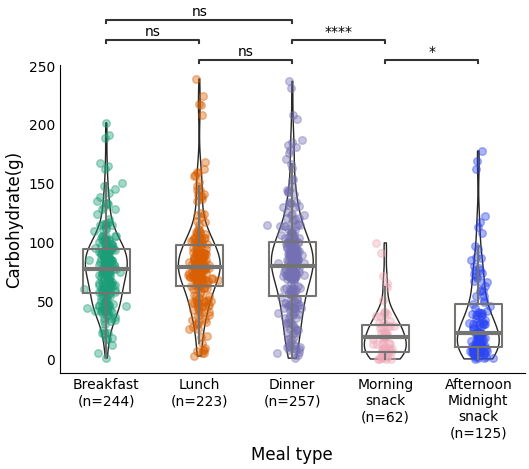

In [138]:
data['Carb(g)'] = data['Carb(g)'].astype(float)
y_data = [data[data["Meal"] == type_]['Carb(g)'].values for type_ in [1,2,3,4,5]]
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3",'#EEA9B8',"#2B45F2"]

fig, ax = plt.subplots(figsize= (6, 4))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("Carbohydrate(g)", size=12)

violins = ax.violinplot(
    y_data, 
    positions=[0,1,2,3,4],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1,2,3,4], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=data,x='Meal',y='Carb(g)',test='t-test_ind',box_pairs=[(2,3),(1,2),(1,3),(4,5),(3,4)], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=0, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['Breakfast','Lunch','Dinner','Morning\nsnack','Afternoon\nMidnight\nsnack'])]
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Meal type", size=12)
plt.savefig('../figure/meal_type_carb_main.jpeg',dpi=300,bbox_inches='tight')
plt.show()

In [9]:
main_meal.groupby('Meal').mean('PPGR_u2')

PPGR_u2     PPGR_u4  Basal_Ins_Use  Basal_Ins_Dose_Unit  GLP1_Use  \
Meal                                                                         
1     118.247268  205.556865       0.254098             8.729508  0.077869   
2      57.006540  139.838565       0.246637             8.479821  0.071749   
3      61.789721  105.628405       0.260700             9.046693  0.089494   

      GLP1_Dose_Total   MFM_Use  MFM_Dose_Total  MFM_Dose_AM  MFM_Dose_Lunch  \
Meal                                                                           
1            4.508197  0.975410       80.122951    44.272541             0.0   
2            4.035874  0.982063       81.345291    44.831839             0.0   
3            5.447471  0.988327       81.653696    44.824903             0.0   

      ...          TG        HDL        LDL  MDRD_eGFR     C_pep  \
Meal  ...                                                          
1     ...  147.053279  44.754098  75.327869  81.024590  1.371721   
2     ...  152.529148  45.004484  74.690583  81.920628  1.404036   
3     ...  149.696498  44.735409  75.330739  82.154864  1.394942   

      C-peptide_index  HOMA IR (C-peptide)    HR(bpm)  AST(IU/L)  ALT(IU/L)  
Meal                                                                         
1           10.823883             0.175061  79.375000  24.250000  27.250000  
2           10.248576             0.183419  80.000000  24.394619  27.995516  
3            9.979006             0.179769  79.068093  24.575875  28.070039  

[3 rows x 58 columns]

UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

<Figure size 1200x1000 with 0 Axes>

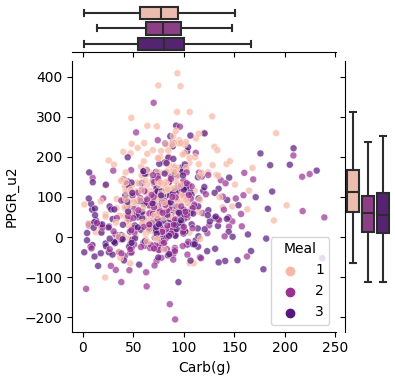

In [6]:
plt.figure(figsize=(12,10))
main_meal = full_data[full_data['Meal'].isin([1,2,3])]
main_meal['Meal'] = main_meal['Meal'].astype(str)
main_meal[PPGR] = main_meal[PPGR].astype(float)
sns.set_palette(sns.color_palette(['#F7B7A3','#9B3192','#57167E']))
g=sns.JointGrid(data=main_meal,x='Carb(g)',y=PPGR, hue='Meal',palette=sns.color_palette(['#F7B7A3','#9B3192','#57167E']),height=4)#,height=4)
sns.boxplot(data=main_meal, x=g.hue, y=g.y, ax=g.ax_marg_y,showfliers = False)
sns.boxplot(data=main_meal, y=g.hue, x=g.x, ax=g.ax_marg_x,showfliers = False)
g.plot_joint(sns.scatterplot,s=25,alpha=0.7)

for _,gr in main_meal.groupby('Meal'):
    sns.regplot(x='Carb(g)', y=PPGR, data=gr, scatter=False, ax=g.ax_joint, truncate=False,ci=None)

#
#plt.xlim(-5,250)
plt.ylim(-240,410)
g.set_axis_labels(xlabel='Carbohydrate(g)',ylabel='PPGR(2h iAUC)')

sns.move_legend(g.ax_joint, "lower right", title='', frameon=True)
texts = g.ax_joint.legend_.texts
for t, label in zip(texts, ['Breakfast','Lunch','Dinner']):
    t.set_text(label)
plt.savefig('../figure/meal_type_joint_main.jpeg',dpi=300)

<Figure size 300x300 with 0 Axes>

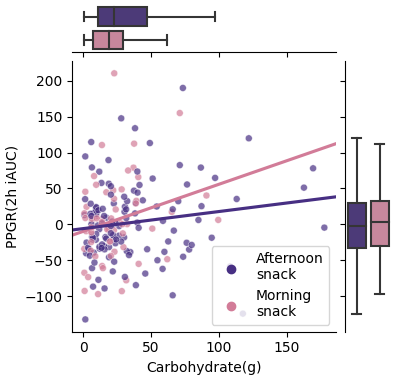

In [328]:
plt.figure(figsize=(3,3))
snack_meal = full_data[full_data['Meal'].isin([4,5])]
snack_meal['Meal'] = snack_meal['Meal'].astype(str)
snack_meal[PPGR] = snack_meal[PPGR].astype(float)
sns.set_palette(sns.color_palette(['#D27C98','#472F83']))
g=sns.JointGrid(data=snack_meal,x='Carb(g)',y=PPGR, hue='Meal',palette=sns.color_palette(['#472F83','#D27C98']),height=4)
sns.boxplot(data=snack_meal, x=g.hue, y=g.y, ax=g.ax_marg_y,showfliers = False,palette=sns.color_palette(['#472F83','#D27C98']))
sns.boxplot(data=snack_meal, y=g.hue, x=g.x, ax=g.ax_marg_x,showfliers = False,palette=sns.color_palette(['#472F83','#D27C98']))
g.plot_joint(sns.scatterplot,s=25,alpha=0.7)

for _,gr in snack_meal.groupby('Meal'):
    sns.regplot(x='Carb(g)', y=PPGR, data=gr, scatter=False, ax=g.ax_joint, truncate=False,ci=None)

g.set_axis_labels(xlabel='Carbohydrate(g)',ylabel='PPGR(2h iAUC)')
sns.move_legend(g.ax_joint, "lower right", title='', frameon=True)

texts = g.ax_joint.legend_.texts
for t, label in zip(texts, ['Afternoon\nsnack','Morning\nsnack']):
    t.set_text(label)
plt.savefig('../figure/meal_type_joint_snack.jpeg',dpi=300)

In [121]:
stats.pearsonr(full_data[full_data['Meal']==3]['Carb(g)'],full_data[full_data['Meal']==3][PPGR])
#stats.pearsonr(full_data[full_data['Meal']==5]['Carb(g)'],full_data[full_data['Meal']==5][PPGR])
#snack_meal[snack_meal['Meal']=='4']['Carb(g)'].mean()
#snack_meal[snack_meal['Meal']=='5']['Carb(g)'].mean()

PearsonRResult(statistic=0.17206405477145442, pvalue=0.005681710063552785)

AttributeError: 'float' object has no attribute 'shape'

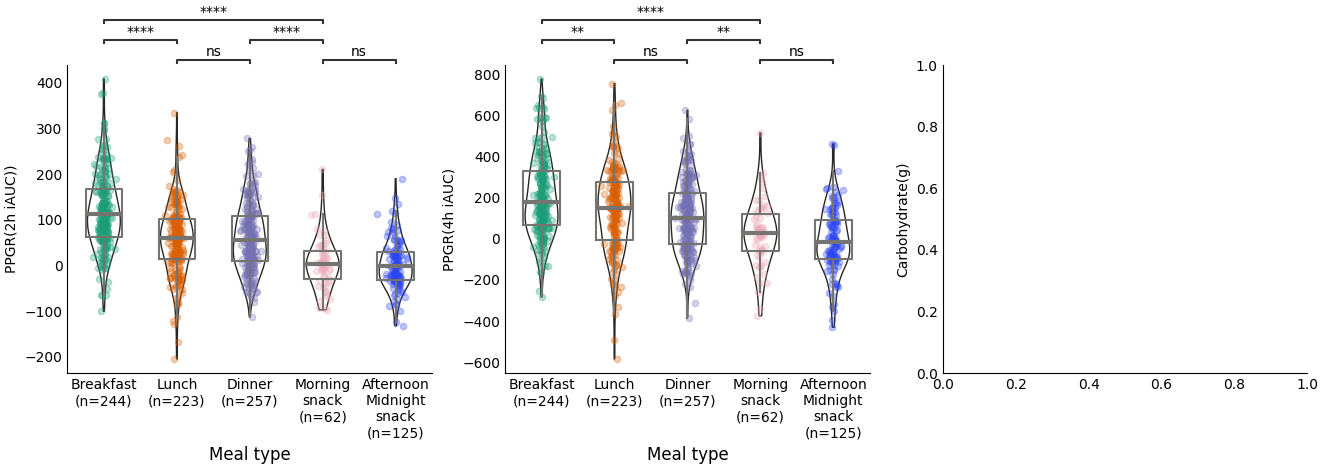

In [34]:
data= full_data
fig,axs = plt.subplots(1,3,figsize=(16,4))
axs[0].set_ylabel("PPGR(2h iAUC))", size=10)
axs[1].set_ylabel("PPGR(4h iAUC)", size=10)
axs[2].set_ylabel("Carbohydrate(g)", size=10)
for ax,col in zip(axs,['PPGR_u2','PPGR_u4','Carb(g)']):
    y_data = [data[data["Meal"] == type_][col].values for type_ in [1,2,3,4,5]]
    jitter = 0.04
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
    x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
    
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.tick_params(length=0)
    
    violins = ax.violinplot(
        y_data, 
        positions=[0,1,2,3,4],
        widths=0.45,
        bw_method="silverman",
        showmeans=False, 
        showmedians=False,
        showextrema=False
    )
    for pc in violins["bodies"]:
        pc.set_facecolor("none")
        pc.set_edgecolor('#282724')
        pc.set_linewidth(1)
        pc.set_alpha(1)
    ax.boxplot(
    y_data,
    positions=[0,1,2,3,4], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
    )
    for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
        ax.scatter(x, y, s = 20, color=color, alpha=0.3)

    add_stat_annotation(ax, data=data,x='Meal',y=col,test='t-test_ind',box_pairs=[(2,3),(1,2),(1,4),(4,5),(3,4)], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=0, show_test_name=False)

    # xlabels accounts for the sample size for each species
    xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['Breakfast','Lunch','Dinner','Morning\nsnack','Afternoon\nMidnight\nsnack'])]
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
    ax.set_xlabel("Meal type", size=12)

plt.subplots_adjust(wspace=0.3)
plt.savefig('../figure/meal_type_main.jpeg',dpi=300,bbox_inches='tight')
plt.show()

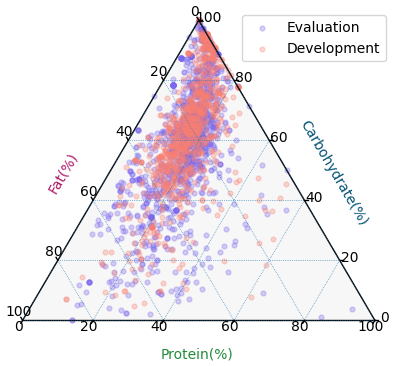

In [23]:
import ternary

fig, tax = ternary.figure(scale=100)
fig.set_size_inches(5, 4.5)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=20)

tax.scatter(evaluation_data[['Protein_pro','Carb_pro','Fat_pro']].values,s=12,alpha=0.3,c="mediumslateblue",label='Evaluation')
tax.scatter(full_data[['Protein_pro','Carb_pro','Fat_pro']].values,s=12,alpha=0.3,c="salmon",label='Development')

tax.ticks(axis='lbr', linewidth=1, multiple=20)
tax.bottom_axis_label("Protein(%)", fontsize=10,color='#228B3B')
tax.right_axis_label("Carbohydrate(%)", fontsize=10,offset=0.14,color='#045275')
tax.left_axis_label("Fat(%)", fontsize=10,offset=0.14,color='#AB1866')
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.legend()
tax.savefig('../figure/ternary_macronutrient_main_eval.jpeg')

tax.show()

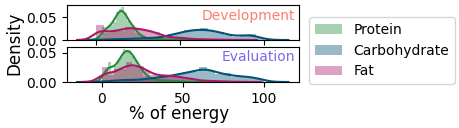

In [29]:
data=full_data
fig,ax = plt.subplots(2,1,figsize=(3,1))
sns.distplot(data['Protein_pro'],label='Protein',color='#228B3B',ax=ax[0])
sns.distplot(data['Carb_pro'],label='Carbohydrate',color='#045275',ax=ax[0])
sns.distplot(data['Fat_pro'],label='Fat',color='#AB1866',ax=ax[0])
ax[0].text(63,0.045,'Development',color='salmon')
data=evaluation_data
sns.distplot(data['Protein_pro'],label='Protein',color='#228B3B',ax=ax[1])
sns.distplot(data['Carb_pro'],label='Carbohydrate',color='#045275',ax=ax[1])
sns.distplot(data['Fat_pro'],label='Fat',color='#AB1866',ax=ax[1])
ax[1].text(74,0.035,'Evaluation',color='mediumslateblue')
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
fig.supxlabel('% of energy',y=-0.3)
fig.supylabel('Density', x=-0.08)
plt.legend(loc='right',bbox_to_anchor=(1.7, 0.9))
plt.savefig('../figure/energy_proportion_main_eval.jpeg',dpi=300)
plt.show()

In [47]:
full_data['ID'].value_counts()

ID
R37    29
R15    27
R38    27
R47    26
R39    25
R36    25
R02    24
R13    24
R28    24
R30    22
R32    21
R35    21
R04    21
R40    20
R41    20
R34    19
R18    19
R19    19
R20    19
R43    19
R01    19
R24    18
R33    18
R25    18
R06    18
R21    18
R17    18
R16    18
R12    18
R10    18
R27    17
R05    17
R08    17
R09    16
R44    16
R42    16
R26    16
R45    15
R11    15
R03    15
R29    15
R22    15
R07    14
R49    14
R46    14
R23    13
R14    12
R50    12
R48    10
Name: count, dtype: int64

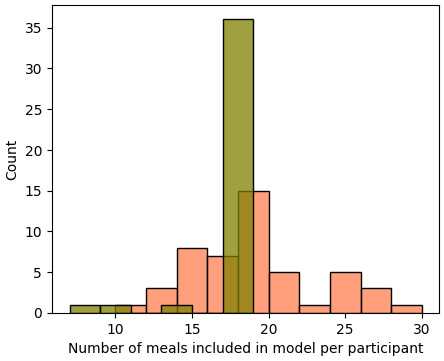

In [46]:
plt.figure(figsize=(5,4))
sns.histplot(full_data['ID'].value_counts(), binwidth=2, color='coral')
sns.histplot(evaluation_data['ID'].value_counts(), binwidth=2, color='olive')
plt.xlabel('Number of meals included in model per participant')
#plt.savefig('../figure/num_meal_total.jpeg',dpi=300)
plt.show()

# Carbohydrate sensitivity

In [74]:
samples = list(full_data['ID'].unique())
carb_sensitivity = []
carb_sensitivity_p = []
for sample in samples:
    data = full_data[full_data['ID']==sample]
    r,p = stats.pearsonr(data['Carb(g)'],data[PPGR])
    carb_sensitivity.append(r)
    carb_sensitivity_p.append(p)
    print(sample, np.round(r,3))
mean_carb_sen = np.mean(carb_sensitivity)
print(mean_carb_sen)

samples = list(evaluation_data['ID'].unique())
carb_sensitivity_eval = []
carb_sensitivity_p_eval = []
for sample in samples:
    data = evaluation_data[evaluation_data['ID']==sample]
    r,p = stats.pearsonr(data['Carb(g)'],data[PPGR])
    carb_sensitivity_eval.append(r)
    carb_sensitivity_p_eval.append(p)
    print(sample, np.round(r,3))

R01 0.737
R02 0.586
R03 0.386
R04 0.406
R05 0.386
R06 0.7
R07 0.03
R08 0.496
R09 0.016
R10 0.467
R11 0.22
R12 0.576
R13 0.745
R14 0.133
R15 0.591
R16 0.33
R17 0.472
R18 -0.096
R19 0.292
R20 0.231
R21 0.182
R22 0.028
R23 0.101
R24 0.668
R25 0.502
R26 0.673
R27 0.197
R28 0.636
R29 -0.144
R30 -0.102
R32 0.499
R33 0.428
R34 0.513
R35 0.528
R36 0.004
R37 0.537
R38 0.584
R39 0.511
R40 0.113
R41 0.647
R42 0.195
R43 0.684
R44 0.135
R45 0.5
R46 0.456
R47 0.704
R48 0.572
R49 0.083
R50 0.717
0.3848843036703643
C0001 0.536
C0002 0.178
C0004 0.433
C0006 0.556
C0007 0.382
C0008 0.538
C0009 -0.25
C0011 0.354
C0012 0.625
C0013 0.146
C0014 0.386
C0015 0.191
C0016 0.591
C0017 0.503
C0019 0.487
C0020 0.679
C0023 0.222
C0026 0.064
C0027 0.582
C0028 0.317
C0029 0.186
C0031 0.511
C0032 0.328
C0033 0.346
C0034 0.106
C0037 0.236
C0038 0.294
C0039 0.476
C0040 0.545
C0041 0.213
C0042 0.385
C0043 0.12
C0044 0.503
C0045 0.305
C0046 0.375
C0047 0.155
C0048 0.432
C0049 0.191
C0051 0.283


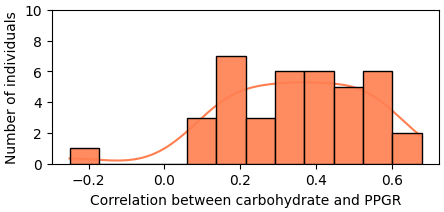

In [77]:
fig, ax = plt.subplots(figsize=(5,2))

#ax.axvspan(-0.3, mean_carb_sen, facecolor='#6E8B3D', alpha=0.3)
#ax.axvspan(mean_carb_sen, 1.0, facecolor='#E3CF57', alpha=0.3)

ax = sns.histplot(carb_sensitivity_eval,bins=12,color='coral',zorder=3,alpha=0.9,kde=True)
#ax.axvline(x=mean_carb_sen,label='mean',zorder=0,color='black',linestyle='--')
plt.xlabel("Correlation between carbohydrate and PPGR")
plt.ylabel("Number of individuals")
plt.ylim(0,10)
#plt.xlim(-0.3,0.85)
#plt.text(-0.05,9,'Low responder\n     (n=23)',color='#637049',weight='bold')
#plt.text(0.48,9,'High responder\n     (n=16)',color='#C88E5B',weight='bold')
#plt.text(mean_carb_sen-0.05,6,'Mean',color='black',rotation=90)
plt.savefig('../figure/carb_sen_eval.jpeg',bbox_inches='tight',dpi=300)
plt.show()

In [75]:
samples = list(full_data['ID'].unique())
carb_sensitivity_df = pd.DataFrame({'ID':samples,'R':carb_sensitivity,'p':carb_sensitivity_p})#,
#carb_sensitivity_df.loc[carb_sensitivity_df['R']>=mean_carb_sen,'carb_sen']='high responder'
#carb_sensitivity_df.loc[carb_sensitivity_df['R']<mean_carb_sen,'carb_sen']='low responder'
carb_sensitivity_df.loc[carb_sensitivity_df['p']<=0.05,'carb_sen']='high responder'
carb_sensitivity_df.loc[carb_sensitivity_df['p']>0.05,'carb_sen']='low responder'
carb_sensitivity_df['carb_sen'].value_counts()

carb_sen
low responder     27
high responder    22
Name: count, dtype: int64

In [144]:
carb_sensitivity_df[carb_sensitivity_df['carb_sen']=='low responder'].R.min()

-0.14372879593874374

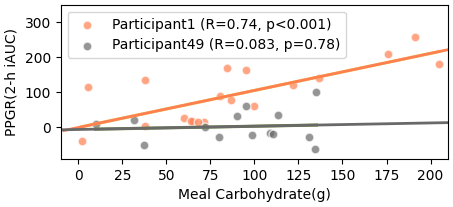

In [23]:
import scipy.stats

plt.figure(figsize=(5,2))

# High sensitivity (R01)
data_R01 = full_data[full_data['ID']=='R01']
ax = sns.regplot(x=data_R01['Carb(g)'].astype(float),y=data_R01[PPGR],scatter_kws={"fc":"coral", "ec":"white", "s":40, "alpha":0.7},color='#E3CF57',
                 ci=None,label=f'Participant1 (R={np.round(carb_sensitivity[0],2)}, p<0.001)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=data_R01['Carb(g)'].astype(float),y=data_R01[PPGR])
xlims = ax.get_xlim()
new_x = np.arange(xlims[0], xlims[1],(xlims[1]-xlims[0])/250.)
ax.plot(new_x, intercept + slope *  new_x, color='coral', linestyle='-', lw = 2)


# Low sensitivity (R49)
data_R49 =full_data[full_data['ID']=='R49']
ax = sns.regplot(x=data_R49['Carb(g)'].astype(float),y=data_R49[PPGR],scatter_kws={"fc":'dimgrey', "ec":"white", "s":40, "alpha":0.7},color='#6E8B3D',
                 ci=None,label=f'Participant49 (R={np.round(carb_sensitivity[47],3)}, p=0.78)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=data_R49['Carb(g)'].astype(float),y=data_R49[PPGR])
xlims = ax.get_xlim()
new_x = np.arange(xlims[0], xlims[1],(xlims[1]-xlims[0])/250.)
ax.plot(new_x, intercept + slope *  new_x, color='dimgrey', linestyle='-', lw = 2)


plt.ylabel('PPGR(2-h iAUC)')
plt.xlabel('Meal Carbohydrate(g)')
plt.legend()
plt.ylim(-90,350)
plt.xlim(-10,210)
plt.savefig('../figure/glycemic_response.jpeg',dpi=300,bbox_inches='tight')
plt.show()

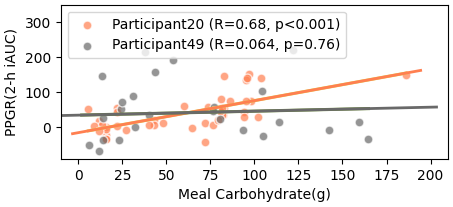

In [112]:
plt.figure(figsize=(5,2))

# High sensitivity (R01)
data_C0020 = evaluation_data[evaluation_data['ID']=='C0020']
ax = sns.regplot(x=data_C0020['Carb(g)'].astype(float),y=data_C0020[PPGR],scatter_kws={"fc":"coral", "ec":"white", "s":40, "alpha":0.7},color='#E3CF57',
                 ci=None,label=f'Participant20 (R={np.round(carb_sensitivity_eval[15],2)}, p<0.001)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=data_C0020['Carb(g)'].astype(float),y=data_C0020[PPGR])
xlims = ax.get_xlim()
new_x = np.arange(xlims[0], xlims[1],(xlims[1]-xlims[0])/250.)
ax.plot(new_x, intercept + slope *  new_x, color='coral', linestyle='-', lw = 2)


# Low sensitivity (R49)
data_C0026 =evaluation_data[evaluation_data['ID']=='C0026']
ax = sns.regplot(x=data_C0026['Carb(g)'].astype(float),y=data_C0026[PPGR],scatter_kws={"fc":'dimgrey', "ec":"white", "s":40, "alpha":0.7},color='#6E8B3D',
                 ci=None,label=f'Participant49 (R={np.round(carb_sensitivity_eval[17],3)}, p=0.76)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=data_C0026['Carb(g)'].astype(float),y=data_C0026[PPGR])
xlims = ax.get_xlim()
new_x = np.arange(xlims[0], xlims[1],(xlims[1]-xlims[0])/250.)
ax.plot(new_x, intercept + slope *  new_x, color='dimgrey', linestyle='-', lw = 2)


plt.ylabel('PPGR(2-h iAUC)')
plt.xlabel('Meal Carbohydrate(g)')
plt.legend(loc='upper left')
plt.ylim(-90,350)
plt.xlim(-10,210)
plt.savefig('../figure/glycemic_response_eval.jpeg',dpi=300,bbox_inches='tight')
plt.show()

In [89]:
main_alpha = pd.read_csv('../data/main_alpha_diversity.csv',index_col=0)
main_alpha

chao1   shannon   simpson  observed
ID                                           
R01  241.250000  4.515327  0.889545       180
R02  248.636364  5.503478  0.954748       220
R03  227.555556  4.844763  0.925972       184
R04  251.794118  4.196201  0.861975       230
R05  374.060000  5.348209  0.936051       314
R06  432.326087  6.263425  0.973858       372
R07  385.459459  5.546632  0.942614       336
R08  340.677419  5.674199  0.942805       331
R09  354.875000  5.706157  0.960464       344
R10  265.882353  4.979044  0.943294       205
R11  192.750000  3.397705  0.802686       114
R12  295.714286  5.282138  0.945242       264
R13  250.370370  5.489606  0.954556       232
R14  201.666667  4.074114  0.850597       190
R15  354.794118  6.245996  0.975448       323
R16  322.222222  5.573280  0.960304       295
R17  202.954545  4.230160  0.908260       171
R18  221.647059  5.691791  0.963730       201
R19  348.000000  4.909558  0.888978       324
R20  389.689655  6.373267  0.976859       360
R21  302.285714  5.892366  0.965147       289
R22  192.043478  4.743499  0.903780       179
R23  266.034483  4.554862  0.886869       253
R24  354.021277  4.455089  0.922196       263
R25  193.583333  3.950975  0.869122       144
R26  252.176471  4.802264  0.930109       183
R27  224.730769  4.043828  0.841619       190
R28  521.000000  5.738047  0.947890       451
R29  467.166667  4.850974  0.924711       354
R30  330.567568  5.524529  0.960306       269
R32  193.176471  4.840468  0.938081       154
R33  304.081081  5.473113  0.955423       283
R34  318.236842  5.528028  0.964068       286
R35  519.769231  6.614249  0.982564       481
R36  365.028571  5.185556  0.893073       346
R37  324.294118  5.504093  0.960542       279
R38  273.230769  4.835391  0.900021       249
R39  132.000000  4.468018  0.926895       115
R40  251.055556  4.610880  0.852854       212
R41  331.500000  5.674089  0.957922       304
R42  247.055556  5.504337  0.961767       214
R43  308.800000  6.028945  0.973804       285
R44  307.176471  5.591402  0.952417       246
R45  428.185185  5.798275  0.957180       386
R46  246.076923  5.329735  0.955031       227
R47  200.772727  4.810093  0.904907       186
R48  189.055556  5.099005  0.948733       175
R49  183.037037  5.426789  0.950499       171
R50  279.320000  4.803847  0.884039       266

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 35.102777777777774 mm


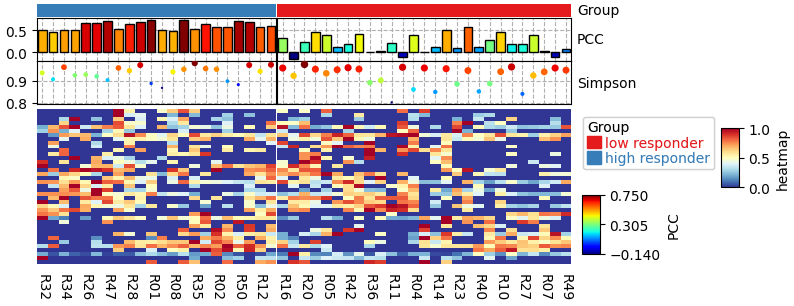

In [98]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
OTU_data_bc = pd.DataFrame(stats.boxcox(OTU_data[microbiome_col],lmbda=0.25),columns=microbiome_col,index=OTU_data.index)
#OTU_data_bc = evaluation_clinical_data[['ID']+microbiome_col]
df_heatmap = pd.merge(OTU_data_bc,carb_sensitivity_df,how='left',on='ID').sort_values('R')
#df_heatmap = pd.merge(df_heatmap,clinical_data[['ID']+cli_col],how='left',on='ID')
df_heatmap = df_heatmap.reindex(sorted(df_heatmap.columns), axis=1)
df_heatmap = df_heatmap.set_index('ID')
df_heatmap[microbiome_col] = scaler.fit_transform(df_heatmap[microbiome_col])
#df_heatmap[cli_col] = scaler.fit_transform(df_heatmap[cli_col])
col_ha = HeatmapAnnotation(Group=anno_simple(df_heatmap.carb_sen,legend=True),axis=1,
                          PCC=anno_barplot(df_heatmap.R),
                          Simpson=anno_scatterplot(main_alpha.simpson,legend=False))

plt.figure(figsize=(7,3))
cm = ClusterMapPlotter(data = df_heatmap[microbiome_col].T, top_annotation = col_ha,cmap='RdYlBu_r',
                       show_colnames=True,col_split=df_heatmap.carb_sen,
                      show_rownames=False,row_cluster=True,row_dendrogram=False,col_cluster=True)#
plt.show()

In [139]:
def plot_CGM(data,target,ax,y_ticks_on=True,title=None,color='dimgrey'):
    sen = data[data['carb_sen']==target]

    ax.set_ylim(50,420)
    ax.plot(sen[CGM_post120_col].T,color="#BFBFBF",  lw=1,alpha=0.3)#BFBFBF
    if y_ticks_on==False:
        ax.set_yticks([])
        mean_label=None
        median_label=None
    else:
        ax.set_yticks([100,200,300,400])
        ax.set_yticklabels([100,200,300,400] )
    CGM_post120_col_skip = [col for i,col in enumerate(CGM_post120_col) if i%4==0]
    ax.errorbar(x=CGM_post120_col_skip,y=sen[CGM_post120_col_skip].mean(axis=0), yerr=sen[CGM_post120_col_skip].std(axis=0),marker='o', markersize=8, color=color,markeredgecolor=color,lw=1.5)

    ax.tick_params(bottom=False)
    ax.set_frame_on(False)
    
    ax.set_xticks(['p_000','p_020','p_040','p_060','p_080','p_100','p_120'])
    ax.set_xticklabels(['0','20','40','60','80','100','120'])

    ax.set_title(title,fontsize=10,y=0.9)

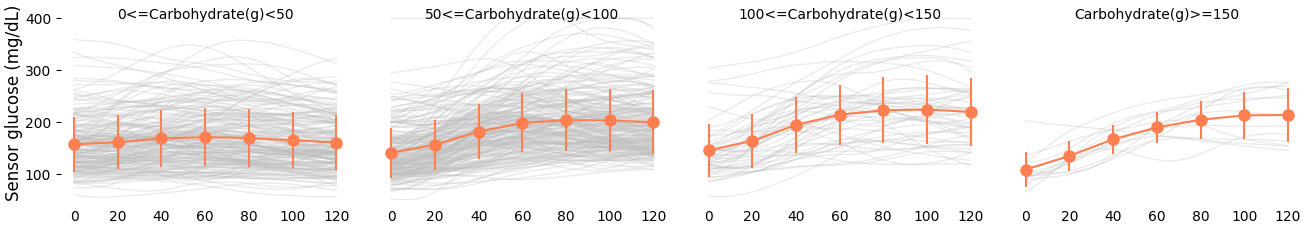

In [140]:
full_data2 = pd.merge(full_data,carb_sensitivity_df,on='ID',how='left')

carb_0_50 = full_data2[(full_data2['Carb(g)']<50) & (full_data2['Carb(g)']>=0)]
carb_50_100 = full_data2[(full_data2['Carb(g)']<100) & (full_data2['Carb(g)']>=50)]
carb_100_150 = full_data2[(full_data2['Carb(g)']<150) & (full_data2['Carb(g)']>=100)]
carb_150 = full_data2[full_data2['Carb(g)']>=150]
titles = ['0<=Carbohydrate(g)<50','50<=Carbohydrate(g)<100','100<=Carbohydrate(g)<150','Carbohydrate(g)>=150']
fig, ax = plt.subplots(1,4,figsize=(16, 2.5))
plot_CGM(carb_0_50,'high responder',ax[0],True,titles[0],color='coral')
plot_CGM(carb_50_100,'high responder',ax[1],False,titles[1],color='coral')
plot_CGM(carb_100_150,'high responder',ax[2],False,titles[2],color='coral')
plot_CGM(carb_150,'high responder',ax[3],False,titles[3],color='coral')

fig.supylabel('Sensor glucose (mg/dL)',x=0.09)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../figure/2hPPGR_lineplot_eval_high.jpeg',dpi=300, bbox_inches='tight')
plt.show()

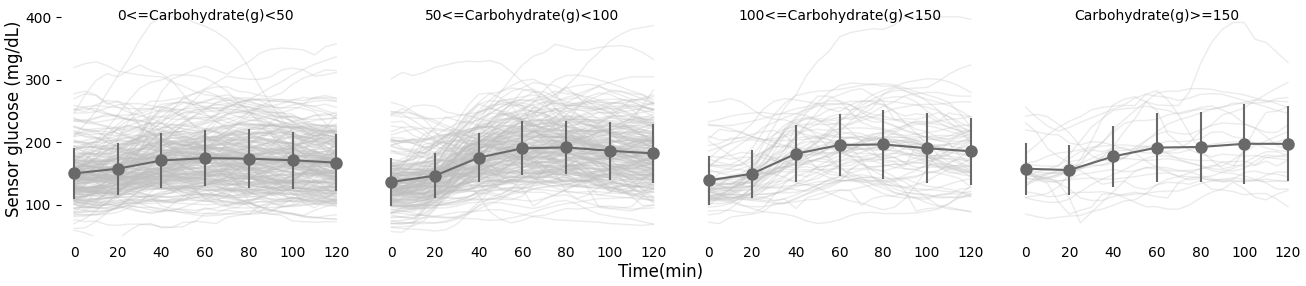

In [92]:
#full_data2 = pd.merge(evaluation_data,carb_sensitivity_df,on='ID',how='left')

carb_0_50 = full_data2[(full_data2['Carb(g)']<50) & (full_data2['Carb(g)']>=0)]
carb_50_100 = full_data2[(full_data2['Carb(g)']<100) & (full_data2['Carb(g)']>=50)]
carb_100_150 = full_data2[(full_data2['Carb(g)']<150) & (full_data2['Carb(g)']>=100)]
carb_150 = full_data2[full_data2['Carb(g)']>=150]
titles = ['0<=Carbohydrate(g)<50','50<=Carbohydrate(g)<100','100<=Carbohydrate(g)<150','Carbohydrate(g)>=150']
fig, ax = plt.subplots(1,4,figsize=(16, 3))
plot_CGM(carb_0_50,'low responder',ax[0],True,titles[0])
plot_CGM(carb_50_100,'low responder',ax[1],False,titles[1])
plot_CGM(carb_100_150,'low responder',ax[2],False,titles[2])
plot_CGM(carb_150,'low responder',ax[3],False,titles[3])

fig.supxlabel('Time(min)',y=-0.04)
fig.supylabel('Sensor glucose (mg/dL)',x=0.09)
plt.subplots_adjust(wspace=0.1)
plt.savefig('../figure/2hPPGR_lineplot_eval_low.jpeg',dpi=300, bbox_inches='tight')

plt.show()

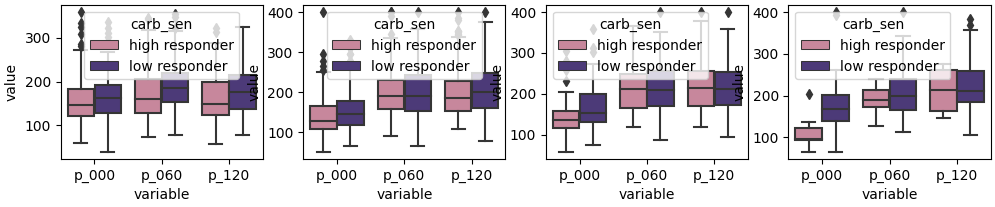

In [350]:
targetCGM = ['p_000','p_060','p_120']

fig,axs = plt.subplots(1,4,figsize=(12,2))
sns.boxplot(data=carb_0_50.melt(id_vars=['ID','carb_sen'],value_vars=targetCGM),x='variable',y='value',hue='carb_sen',ax=axs[0])
sns.boxplot(data=carb_50_100.melt(id_vars=['ID','carb_sen'],value_vars=targetCGM),x='variable',y='value',hue='carb_sen',ax=axs[1])
sns.boxplot(data=carb_100_150.melt(id_vars=['ID','carb_sen'],value_vars=targetCGM),x='variable',y='value',hue='carb_sen',ax=axs[2])
sns.boxplot(data=carb_150.melt(id_vars=['ID','carb_sen'],value_vars=targetCGM),x='variable',y='value',hue='carb_sen',ax=axs[3])
#plt.xticks(['p_000','p_020','p_040','p_060','p_080','p_100','p_120'])
#plt.xticklabels(['0','20','40','60','80','100','120'])
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=6.197e-04 stat=-3.435e+00


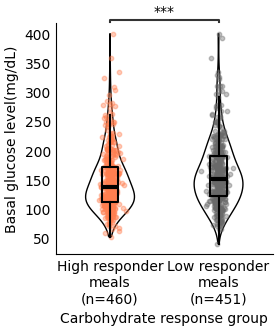

In [141]:
full_data2['p_000'] = full_data2['p_000'].astype(float)
y_data = [full_data2[full_data2["carb_sen"] == type_]['p_000'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["coral", "dimgrey"]

fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("Basal glucose level(mg/dL)", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('black')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="black",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="black"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 10, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=full_data2,x='carb_sen',y='p_000',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder\nmeals','Low responder\nmeals'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/HbA1c_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

In [144]:
full_data2['glycemia_status'] = full_data2['p_120'].apply(lambda x: 'hyperglycemia' if x > 200 else 'normal')

# 교차표 생성
contingency_table = pd.crosstab(full_data2['carb_sen'], full_data2['glycemia_status'])

# 카이제곱 검정 수행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print(f'Chi2: {chi2}, p-value: {p}')

Chi2: 10.765704386856367, p-value: 0.001033982059174676


In [145]:
contingency_table

glycemia_status  hyperglycemia  normal
carb_sen                              
high responder             163     297
low responder              209     242

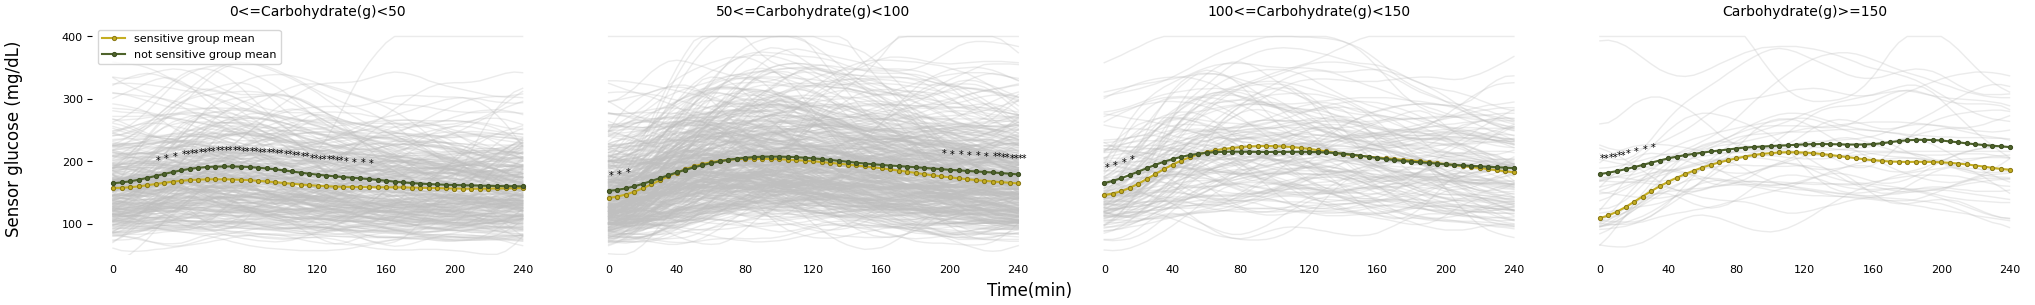

In [445]:
def plot_CGM2(data,ax,y_ticks_on=True,title=None):
    sen = data[data['carb_sen']=='high responder']
    not_sen = data[data['carb_sen']=='low responder']

    # 각 time point의 그룹간 비교 (t-test)
    p_list = []
    for col in CGM_post240_col:
        res = stats.ttest_ind(sen[col].astype(float),not_sen[col].astype(float))
        if 0.01<res.pvalue<=0.05:
            p_list.append('*')
        elif 0.001<res.pvalue<=0.01:
            p_list.append('**')
        elif res.pvalue<=0.001:
            p_list.append('***')
        else:
            p_list.append('')
            
    ax.set_ylim(50,420)
    ax.plot(sen[CGM_post240_col].T,color="#BFBFBF",  lw=1,alpha=0.3)
    ax.plot(not_sen[CGM_post240_col].T,color="#BFBFBF",  lw=1,alpha=0.3)
    high_label='sensitive group mean'
    low_label='not sensitive group mean'
    if y_ticks_on==False:
        ax.set_yticks([])
        mean_label=None
        median_label=None
    else:
        ax.set_yticks([100,200,300,400])
        ax.set_yticklabels([100,200,300,400] ,fontsize=8)
    sns.lineplot(sen[CGM_post240_col].mean(axis=0), marker='o', markersize=3, color="#C5AE21",markeredgecolor='#8B7A17', ax=ax, label=high_label,lw=1.5)
    sns.lineplot(not_sen[CGM_post240_col].mean(axis=0), marker='o', markersize=3, color="#4E632B",markeredgecolor='#3D4E22', ax=ax, label=low_label,lw=1.5)
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)
    
    ax.set_xticks(['p_000','p_040','p_080','p_120','p_160','p_200','p_240'])
    ax.set_xticklabels(['0','40','80','120','160','200','240'], fontsize=8)
    ax.set_title(title,fontsize=10)
    for i,col in enumerate(CGM_post240_col):
        ax.text(col,not_sen[col].mean()+20,p_list[i],fontsize=7)
    if y_ticks_on:
        ax.legend(loc='upper left',fontsize=8)
    else: ax.legend().set_visible(False)

fig, ax = plt.subplots(1,4,figsize=(25, 3))
plot_CGM2(carb_0_50,ax[0],True,titles[0])
plot_CGM2(carb_50_100,ax[1],False,titles[1])
plot_CGM2(carb_100_150,ax[2],False,titles[2])
plot_CGM2(carb_150,ax[3],False,titles[3])

fig.supxlabel('Time(min)',y=-0.04)
fig.supylabel('Sensor glucose (mg/dL)',x=0.09)
plt.subplots_adjust(wspace=0.1)
plt.savefig('../figure/4hPPGR_lineplot_eval.jpeg',dpi=300, bbox_inches='tight')
plt.show()

Text(0, 0.5, 'PPGR (2h iAUC)')

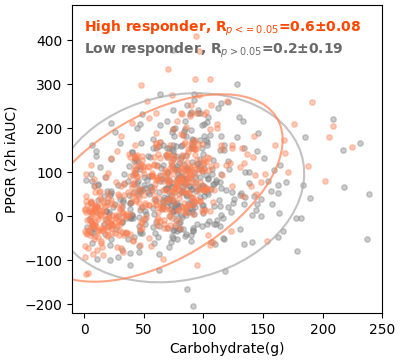

In [439]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=5.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
    
sen = full_data2[full_data2['carb_sen']=='high responder']
not_sen = full_data2[full_data2['carb_sen']=='low responder']
fig,ax=plt.subplots(figsize=(4,4))

ax.scatter(data=not_sen,x='Carb(g)',y='PPGR_u2',color='grey',s=15,alpha=0.4)
ax.scatter(data=sen,x='Carb(g)',y='PPGR_u2',color='coral',s=15,alpha=0.4)
confidence_ellipse(not_sen['Carb(g)'].astype(float), not_sen['PPGR_u2'].astype(float), ax, n_std=2.58,alpha=0.7, facecolor='None', edgecolor='darkgrey',linewidth=1.5)
confidence_ellipse(sen['Carb(g)'].astype(float), sen['PPGR_u2'].astype(float), ax, n_std=2.58,alpha=0.7, facecolor='None', edgecolor='coral',linewidth=1.5)
ax.text(0,420,'High responder, R'+r"$_{p<=0.05}$"+'={}±{}'.format(np.round(sen['R'].mean(),2),np.round(sen['R'].std(),2)),fontsize=10,color='orangered', weight='bold')
ax.text(0,370,'Low responder, R'+r"$_{p>0.05}$"+'={}±{}'.format(np.round(not_sen['R'].mean(),2),np.round(not_sen['R'].std(),2)),fontsize=10,color='dimgrey', weight='bold')
ax.set_xlim(-10,250)
ax.set_ylim(-220,480)
ax.set_xlabel('Carbohydrate(g)')
ax.set_ylabel('PPGR (2h iAUC)')

In [52]:
med_var = ['Basal_Ins_Use','MFM_Use','GLP1_Use','SU_Use','DPP4i_Use','SGLT2i_Use','TZD_Use']
## Main data
carb_sensitivity_clinical_df = pd.merge(clinical_data,med_data[['ID']+med_var],on='ID')
carb_sensitivity_clinical_df = pd.merge(carb_sensitivity_clinical_df,carb_sensitivity_df,on='ID')
main_alpha = pd.read_csv('../data/main_alpha_diversity.csv',index_col=0).reset_index()
carb_sensitivity_clinical_df = pd.merge(carb_sensitivity_clinical_df,main_alpha,on='ID',how='left')

## Evaluation data
#carb_sensitivity_clinical_df = pd.merge(evaluation_clinical_data,carb_sensitivity_df,on='ID')

sen = carb_sensitivity_clinical_df[carb_sensitivity_clinical_df['carb_sen']=='high responder']
not_sen = carb_sensitivity_clinical_df[carb_sensitivity_clinical_df['carb_sen']=='low responder']
category_var = ['Sex','Insulin_use(Basal)','BP_med','Dyslipidemia_med','HTN','Dyslipidemia']
cpep_var = ['C_pep','C-peptide_index','HOMA IR (C-peptide)']
diversity_var = ['shannon','simpson']

for col in continuous_var:
    res = stats.ttest_ind(sen[col],not_sen[col],equal_var=True)
    print(col)
    print(res)
    print()
print('-----')
for col in med_var:
    pivot = carb_sensitivity_clinical_df.pivot_table(index='carb_sen',columns=col,aggfunc='size')
    res = stats.chi2_contingency(pivot)
    print(col)
    print(res)
    print()
print('-----')
for col in diversity_var:
    res = stats.ttest_ind(sen[col],not_sen[col],equal_var=True)
    print(col)
    print(res)

Age
TtestResult(statistic=0.170871453031674, pvalue=0.8650583428254295, df=47.0)

DM_Duration
TtestResult(statistic=0.7655609820437734, pvalue=0.44776514644989085, df=47.0)

BMI
TtestResult(statistic=-0.36728351761905287, pvalue=0.7150562068721944, df=47.0)

Weight(kg)
TtestResult(statistic=0.27557912982245314, pvalue=0.7840793587326835, df=47.0)

Waist_Circumference(cm)
TtestResult(statistic=-0.325453318583897, pvalue=0.7462824809199361, df=47.0)

SBP
TtestResult(statistic=0.07259294520460975, pvalue=0.9424380926172293, df=47.0)

DBP
TtestResult(statistic=-0.6162920014229706, pvalue=0.5406754423944338, df=47.0)

FBS
TtestResult(statistic=-0.4838209811130723, pvalue=0.6307596207460683, df=47.0)

HbA1c
TtestResult(statistic=-1.4723822320680078, pvalue=0.1475830123807131, df=47.0)

Total_chol
TtestResult(statistic=-0.32684608208087795, pvalue=0.7452354874913871, df=47.0)

TG
TtestResult(statistic=-0.5474992805215237, pvalue=0.5866264526247054, df=47.0)

HDL
TtestResult(statistic=0.374237

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=1.476e-01 stat=-1.472e+00


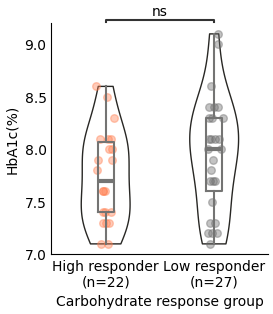

In [61]:
y_data = [carb_sensitivity_clinical_df[carb_sensitivity_clinical_df["carb_sen"] == type_]['HbA1c'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["coral", "dimgrey"]

fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("HbA1c(%)", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=carb_sensitivity_clinical_df,x='carb_sen',y='HbA1c',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder','Low responder'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/HbA1c_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=4.478e-01 stat=7.656e-01


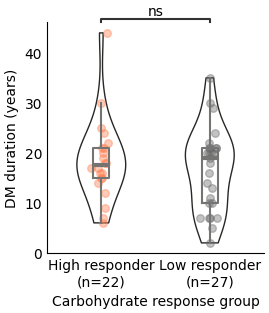

In [62]:
y_data = [carb_sensitivity_clinical_df[carb_sensitivity_clinical_df["carb_sen"] == type_]['DM_Duration'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["coral", "dimgrey"]

fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("DM duration (years)", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=carb_sensitivity_clinical_df,x='carb_sen',y='DM_Duration',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder','Low responder'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/DMduration_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=6.535e-03 stat=-2.882e+00


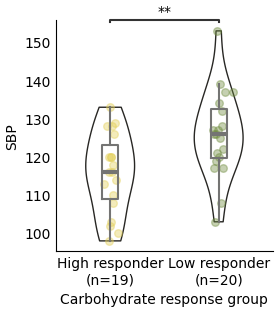

In [294]:
y_data = [carb_sensitivity_clinical_df[carb_sensitivity_clinical_df["carb_sen"] == type_]['SBP'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#E3CF57", "#6E8B3D"]

fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("SBP", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=carb_sensitivity_clinical_df,x='carb_sen',y='SBP',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)
# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder','Low responder'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/DMduration_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=3.198e-01 stat=-1.006e+00


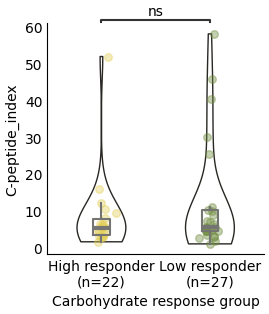

In [157]:
y_data = [carb_sensitivity_clinical_df[carb_sensitivity_clinical_df["carb_sen"] == type_]['C-peptide_index'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#E3CF57", "#6E8B3D"]

fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("C-peptide_index", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=carb_sensitivity_clinical_df,x='carb_sen',y='C-peptide_index',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)
# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder','Low responder'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/DMduration_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=2.552e-01 stat=1.152e+00


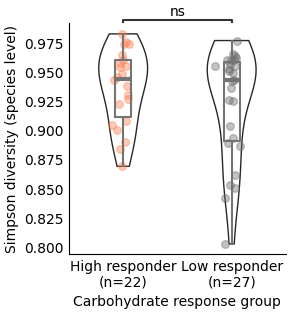

In [60]:
y_data = [carb_sensitivity_clinical_df[carb_sensitivity_clinical_df["carb_sen"] == type_]['simpson'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["coral", "dimgrey"]
fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("Simpson diversity (species level)", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=carb_sensitivity_clinical_df,x='carb_sen',y='simpson',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder','Low responder'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/DMduration_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

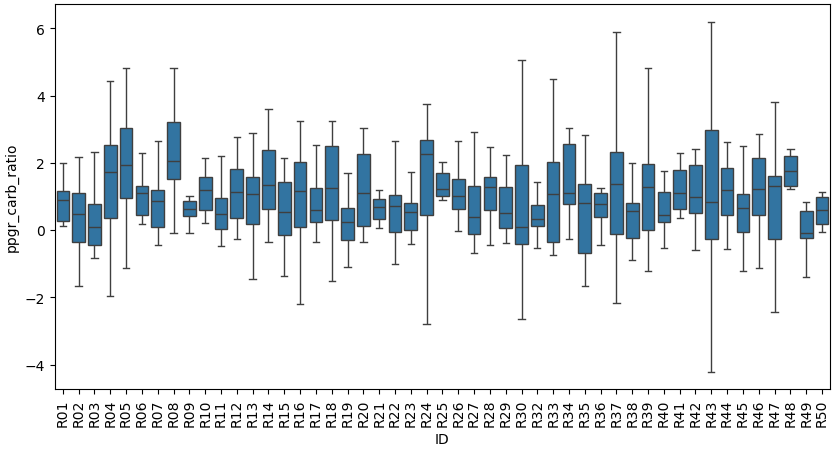

In [108]:
full_data['ppgr_carb_ratio'] = full_data['PPGR_u2']/full_data['Carb(g)']
plt.figure(figsize=(10,5))
sns.boxplot(data=full_data,x='ID',y='ppgr_carb_ratio',showfliers = False)
plt.xticks(rotation=90)
plt.show()

In [31]:
def collapse_otu(df, level):
    OTU_ = pd.DataFrame()
    OTU_list=df.columns
    level_list = list(set([';'.join(OTU.split(';')[0:level]) for OTU in OTU_list]))
    for i in range(len(level_list)):
        the_otu = [OTU for OTU in df.columns if level_list[i] in OTU]
        OTU_[level_list[i]] = df[the_otu].sum(axis=1)
        
    return OTU_

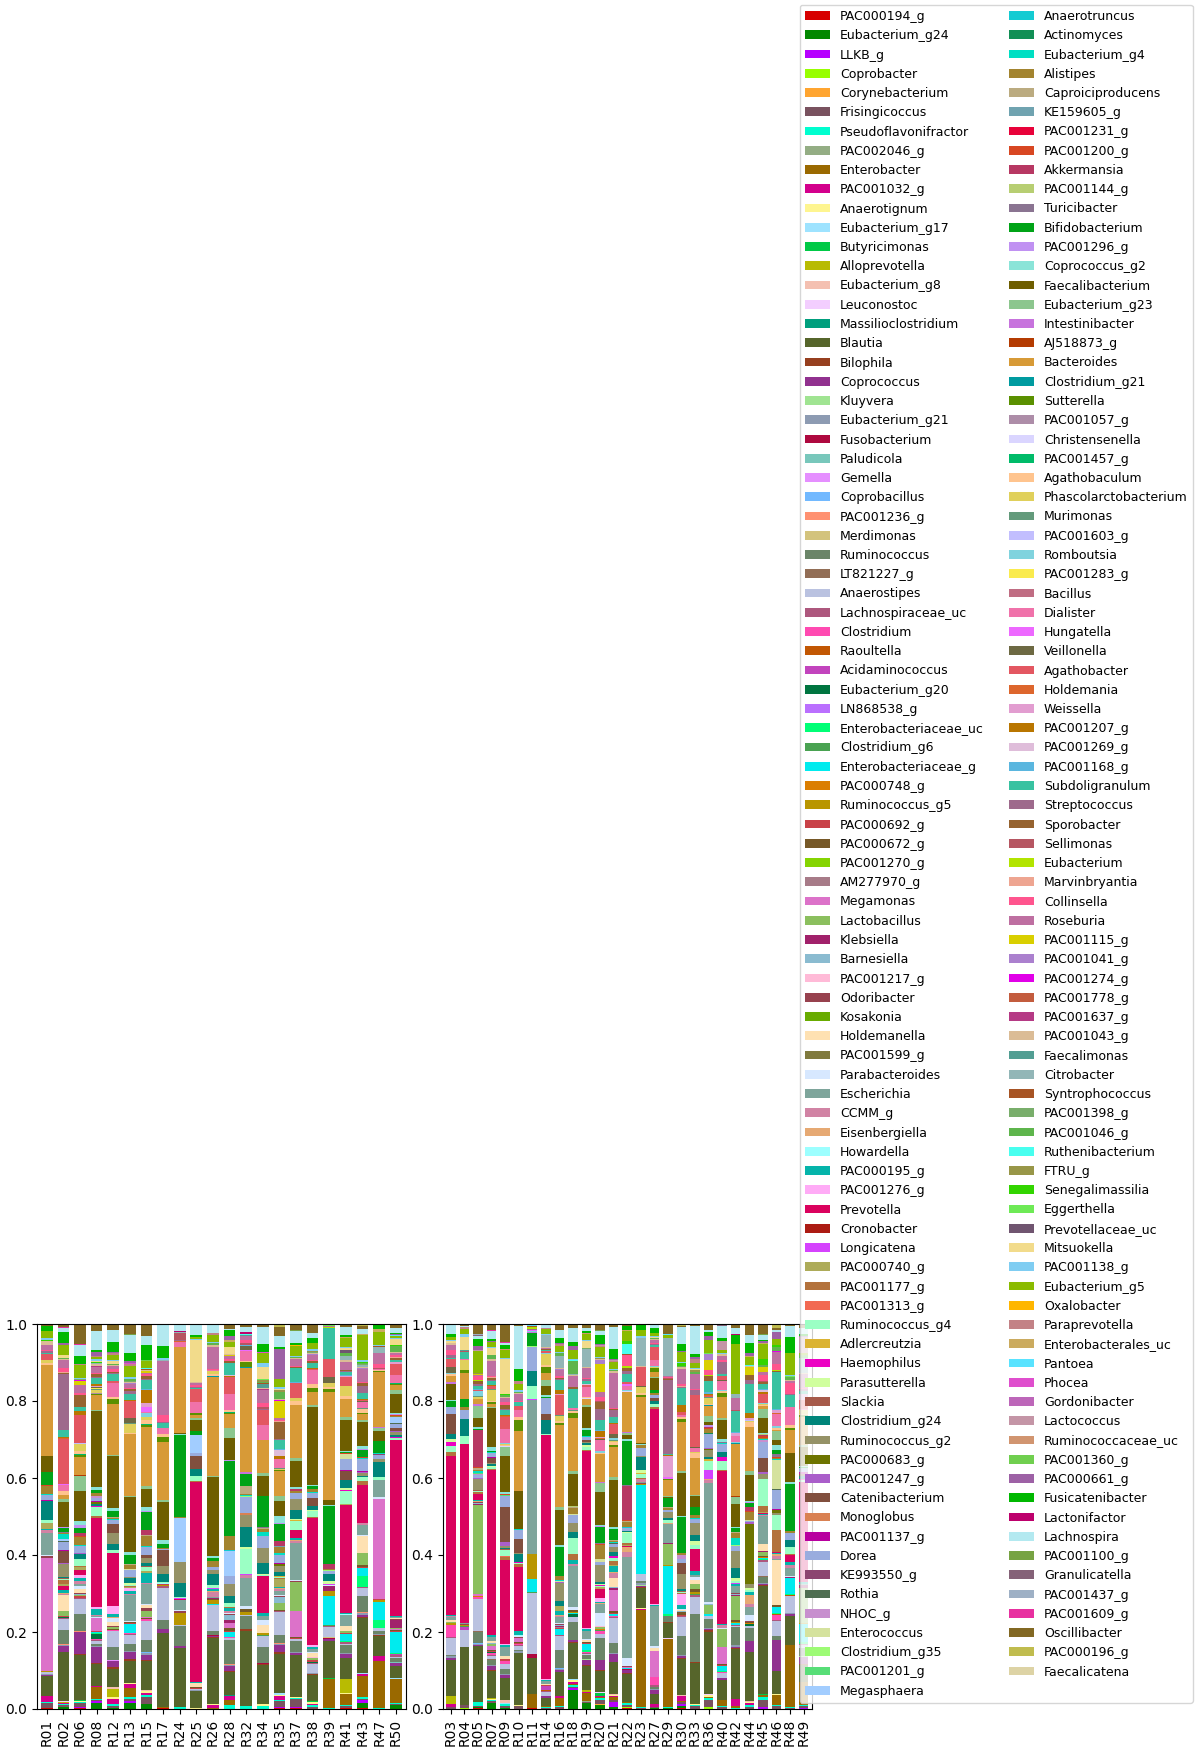

In [41]:
import colorcet as cc

selected_genus = list(collapse_otu(OTU_data[microbiome_col], 6).columns)
selected_genus.append('Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella')
#evaluation_OTU_data=evaluation_clinical_data.iloc[:,-598:]
#evaluation_OTU_data.index = evaluation_clinical_data['ID']
genus = collapse_otu(OTU_data, 6)

# selected에 없는 건 Other로 분류
#genus['Others'] = genus.drop(selected_genus,axis=1).sum(axis=1)
#genus = genus[selected_genus+['Others']]

genus.columns = [var.split(';')[-1] for var in genus.columns]
tmp = pd.merge(carb_sensitivity_df,genus,left_on='ID',right_index=True).set_index('ID')
high = tmp.loc[tmp['carb_sen']=='high responder',genus.columns]
low = tmp.loc[tmp['carb_sen']=='low responder',genus.columns]
#genus_bar = pd.DataFrame([high.sum(),low.sum()],index=['high','low'])
high_bar = high.div(high.sum(axis=1),axis=0)
low_bar = low.div(low.sum(axis=1),axis=0)
fig,ax = plt.subplots(1,2)
high_bar.plot(kind='bar',stacked=True,figsize=(10,5),width=0.7,colormap=cc.cm.glasbey_light,ax=ax[0])
low_bar.plot(kind='bar',stacked=True,figsize=(10,5),width=0.7,colormap=cc.cm.glasbey_light,ax=ax[1])
ax[0].legend().set_visible(None)
#for i in range(len(genus_bar.columns)):
#    h0 = np.sum([genus_bar.iloc[0,k] for k in range(0, i + 1)])
#    h1 = np.sum([genus_bar.iloc[1,k] for k in range(0, i + 1)])
#    ax.plot([h0, h1],[0.7 / 2, 1 - 0.7 / 2], color='C7', ls='--', zorder=1,linewidth=0.5)
        
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
#plt.ylabel('Relative Frequency')
#plt.xticks([0,1],['High responder','Low responder'],rotation=90)
plt.legend(ncols=2, loc='lower center',bbox_to_anchor=(1.5, -0),fontsize = 9)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../figure/genus_carb_sen.jpeg',dpi=300)
plt.show()

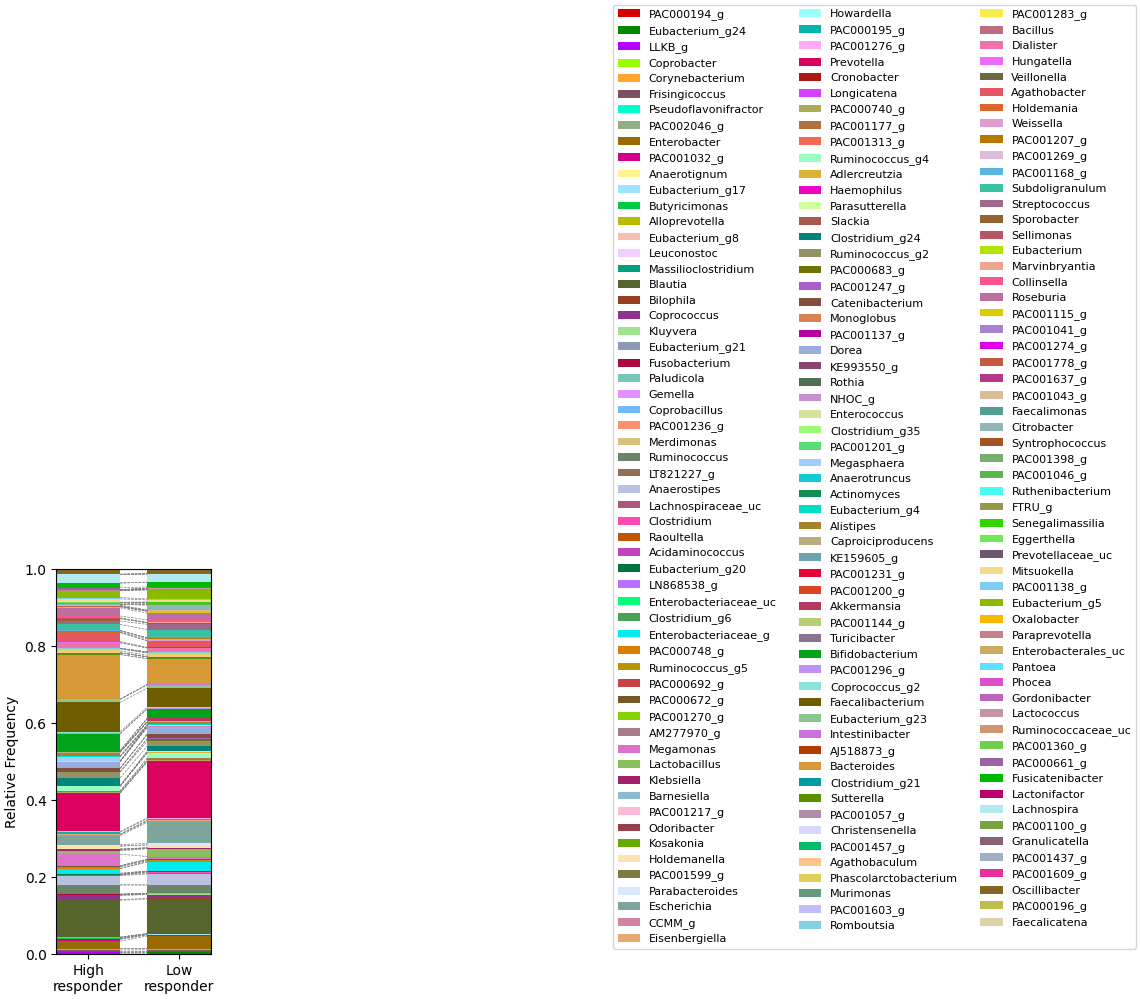

In [43]:
genus = collapse_otu(OTU_data, 6)
# selected에 없는 건 Other로 분류
#genus['Others'] = genus.drop(selected_genus,axis=1).sum(axis=1)
#genus = genus[selected_genus+['Others']]
genus.columns = [var.split(';')[-1] for var in genus.columns]
tmp = pd.merge(carb_sensitivity_df,genus,left_on='ID',right_index=True)
high = tmp.loc[tmp['carb_sen']=='high responder',genus.columns]
low = tmp.loc[tmp['carb_sen']=='low responder',genus.columns]
genus_bar = pd.DataFrame([high.sum(),low.sum()],index=['high','low'])
genus_bar = genus_bar.div(genus_bar.sum(axis=1),axis=0)

ax = genus_bar.plot(kind='bar',stacked=True,figsize=(2,5),width=0.7,colormap=cc.cm.glasbey_light)

for i in range(len(genus_bar.columns)):
    h0 = np.sum([genus_bar.iloc[0,k] for k in range(0, i + 1)])
    h1 = np.sum([genus_bar.iloc[1,k] for k in range(0, i + 1)])
    ax.plot([0.7 / 2, 1 - 0.7 / 2],[h0, h1], color='C7', ls='--', zorder=1,linewidth=0.5)

plt.ylim(0,1)
plt.xlim(-0.35,1.35)
plt.ylabel('Relative Frequency')
plt.xticks([0,1],['High\nresponder','Low\nresponder'],rotation=0)
plt.legend(ncols=3, loc='lower right',bbox_to_anchor=(7, 0),fontsize = 8)
plt.show()

In [77]:
avg_fiber_list =[]
avg_carb_list =[]
avg_protein_list =[]
avg_fat_list =[]
for sample in samples:
    avg_fiber = full_data[full_data['ID']==sample]['Fiber(g)'].mean()
    avg_carb = full_data[full_data['ID']==sample]['Carb(g)'].mean()
    avg_prot = full_data[full_data['ID']==sample]['Protein(g)'].mean()
    avg_fat = full_data[full_data['ID']==sample]['Fat(g)'].mean()
    avg_fiber_list.append(avg_fiber)
    avg_carb_list.append(avg_carb)
    avg_protein_list.append(avg_prot)
    avg_fat_list.append(avg_fat)


tmp = pd.merge(carb_sensitivity_df,genus,left_on='ID',right_index=True)
tmp['avg_fiber'] = avg_fiber_list
tmp['avg_carb'] = avg_carb_list
tmp['avg_prot'] = avg_protein_list
tmp['avg_fat'] = avg_fat_list
high = tmp.loc[tmp['carb_sen']=='high responder',]
low = tmp.loc[tmp['carb_sen']=='low responder',]
print(stats.ttest_ind(high['avg_fiber'],low['avg_fiber']))
print(stats.ttest_ind(high['avg_carb'],low['avg_carb']))
print(stats.ttest_ind(high['avg_prot'],low['avg_prot']))
print(stats.ttest_ind(high['avg_fat'],low['avg_fat']))

TtestResult(statistic=-2.4800509782731743, pvalue=0.01677597900902985, df=47.0)
TtestResult(statistic=-3.2498920983928428, pvalue=0.0021365741229917292, df=47.0)
TtestResult(statistic=-1.9231928306369386, pvalue=0.06052591725683316, df=47.0)
TtestResult(statistic=-0.7598046658909399, pvalue=0.45116584010884475, df=47.0)


In [50]:
full_data2 = pd.merge(full_data,carb_sensitivity_df,how='left',on='ID')
high = full_data2[full_data2['carb_sen']=='high responder']
low = full_data2[full_data2['carb_sen']=='low responder']
print(stats.ttest_ind(high['p_000'].astype(float),low['p_000'].astype(float)))
print((low['p_120']>200).sum()/len(low))
print((high['p_120']>200).sum()/len(high))

TtestResult(statistic=-3.4348722846499298, pvalue=0.0006196512756007212, df=909.0)
0.4634146341463415
0.35434782608695653


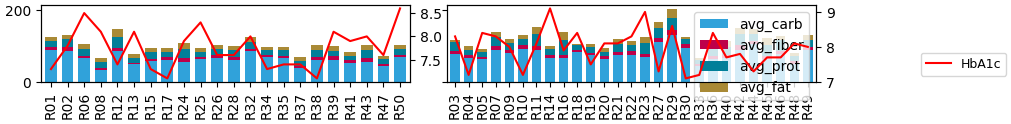

In [78]:
avg_consumption = ['avg_carb','avg_fiber','avg_prot','avg_fat']

fig,ax = plt.subplots(1,2,sharey=True)
ax2_1 = ax[0].twinx()  
ax2_2 = ax[1].twinx()  
high[avg_consumption].plot(kind='bar',stacked=True,figsize=(10,1),width=0.7,ax=ax[0],colormap=cc.cm.glasbey_hv)
low[avg_consumption].plot(kind='bar',stacked=True,figsize=(10,1),width=0.7,ax=ax[1],colormap=cc.cm.glasbey_hv)

tmp = carb_sensitivity_clinical_df
high = tmp.loc[tmp['carb_sen']=='high responder'].set_index('ID')
low = tmp.loc[tmp['carb_sen']=='low responder'].set_index('ID')
high['HbA1c'].plot(ax=ax2_1,figsize=(10,1),color='red')
low['HbA1c'].plot(ax=ax2_2,figsize=(10,1),color='red')


ax[0].legend().set_visible(None)
plt.legend(ncols=2, loc='lower center',bbox_to_anchor=(1.4, -0),fontsize = 9)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
plt.subplots_adjust(wspace=0.1)

(0.0, 210.0)

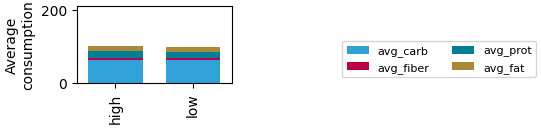

In [244]:
consumption_bar = pd.DataFrame([high[avg_consumption].mean(),low[avg_consumption].mean()],index=['high','low'])
#consumption_bar = consumption_bar[avg_consumption].div(consumption_bar[avg_consumption].sum(axis=1),axis=0)

ax = consumption_bar[avg_consumption].plot(kind='bar',stacked=True,figsize=(2,1),width=0.7,colormap=cc.cm.glasbey_hv)
plt.legend(ncols=2, loc='lower right',bbox_to_anchor=(3, 0),fontsize = 8)
plt.ylabel('Average\nconsumption')
plt.xlim(-0.5,1.5)
plt.ylim(0,210)

In [86]:
tmp = carb_sensitivity_clinical_df
high = tmp.loc[tmp['carb_sen']=='high responder'].set_index('ID')
low = tmp.loc[tmp['carb_sen']=='low responder'].set_index('ID')
print(np.round(high['HbA1c'].mean(),2))
print(np.round(low['HbA1c'].mean(),2))

7.75
7.96


In [44]:
selected_genus_ = [var.split(';')[-1] for var in selected_genus]
for col in genus.columns:
    res = stats.ttest_ind(high[col],low[col],equal_var=True)
    if col=='Prevotella':
        print(col)
        print(res)
        print()
    if res.pvalue<0.05:
        print(col)
        print(res)
        print()

res = stats.ttest_ind(high['Prevotella']/high['Bacteroides'],low['Prevotella']/low['Bacteroides'],equal_var=True)
print("Prevotella/Bacteroides")
print(res)

PAC001236_g
TtestResult(statistic=2.4414541074619125, pvalue=0.018447663931146406, df=47.0)

Clostridium
TtestResult(statistic=-2.03535642615372, pvalue=0.04747546366469927, df=47.0)

Odoribacter
TtestResult(statistic=2.2197378255837847, pvalue=0.0312980801863953, df=47.0)

Prevotella
TtestResult(statistic=-0.9043300398731718, pvalue=0.3704326434147185, df=47.0)

Megasphaera
TtestResult(statistic=2.0525744749789085, pvalue=0.045705270948747635, df=47.0)

Bacteroides
TtestResult(statistic=2.221374856595797, pvalue=0.03117955207378766, df=47.0)

Oxalobacter
TtestResult(statistic=3.2872780305247633, pvalue=0.001919005879759968, df=47.0)

Phocea
TtestResult(statistic=2.2683228227149987, pvalue=0.027945307460246094, df=47.0)

Prevotella/Bacteroides
TtestResult(statistic=-0.8725758150821727, pvalue=0.3873304529663376, df=47.0)


In [64]:
((high['Prevotella']/high['Bacteroides'])>1).sum()/len(high)
(low['Prevotella']/low['Bacteroides'])>1

MannwhitneyuResult(statistic=255.0, pvalue=0.40393884192819174)

In [32]:
selected_family = list(collapse_otu(OTU_data[microbiome_col], 5).columns)
family = collapse_otu(OTU_data, 5)

# selected에 없는 건 Other로 분류
#family['Others'] = family.drop(selected_family,axis=1).sum(axis=1)
#family = family[selected_family+['Others']]

family.columns = [var.split(';')[-1] for var in family.columns]
tmp = pd.merge(carb_sensitivity_df,family,left_on='ID',right_index=True)
high = tmp.loc[tmp['carb_sen']=='high responder',family.columns]
low = tmp.loc[tmp['carb_sen']=='low responder',family.columns]
family_bar = pd.DataFrame([high.mean(),low.mean()],index=['high','low'])

family_bar = family_bar.div(family_bar.sum(axis=1),axis=0)
ax = family_bar.plot(kind='barh',stacked=True,figsize=(4,3),width=0.7,colormap=cc.cm.glasbey_light)

for i in range(len(family_bar.columns)):
    h0 = np.sum([family_bar.iloc[0,k] for k in range(0, i + 1)])
    h1 = np.sum([family_bar.iloc[1,k] for k in range(0, i + 1)])
    ax.plot([h0, h1],[0.7 / 2, 1 - 0.7 / 2], color='C7', ls='--', zorder=1,linewidth=0.5)
    
plt.xlim(0,1)
plt.xlabel('Relative abundance')
plt.yticks([0,1],['High responder','Low responder'],rotation=0)
plt.legend(loc='upper right',bbox_to_anchor=(1.55, 0.95),fontsize = 8)
plt.show()

NameError: name 'carb_sensitivity_df' is not defined

In [22]:
for col in high.columns:
    res = stats.ttest_ind(high[col],low[col],equal_var=True)
    if res.pvalue<0.1:
        print(col)
        print(res)
        print()

Corynebacteriaceae
TtestResult(statistic=-1.748321283850395, pvalue=0.08693809167500598, df=47.0)

Clostridiaceae
TtestResult(statistic=-2.03535642615372, pvalue=0.04747546366469927, df=47.0)

Enterobacteriaceae
TtestResult(statistic=-1.8387158531387848, pvalue=0.07228010480168659, df=47.0)

Bacteroidaceae
TtestResult(statistic=2.221374856595797, pvalue=0.03117955207378766, df=47.0)

Veillonellaceae
TtestResult(statistic=2.2645771071647522, pvalue=0.028191940039443416, df=47.0)

Oxalobacteraceae
TtestResult(statistic=3.2872780305247633, pvalue=0.001919005879759968, df=47.0)



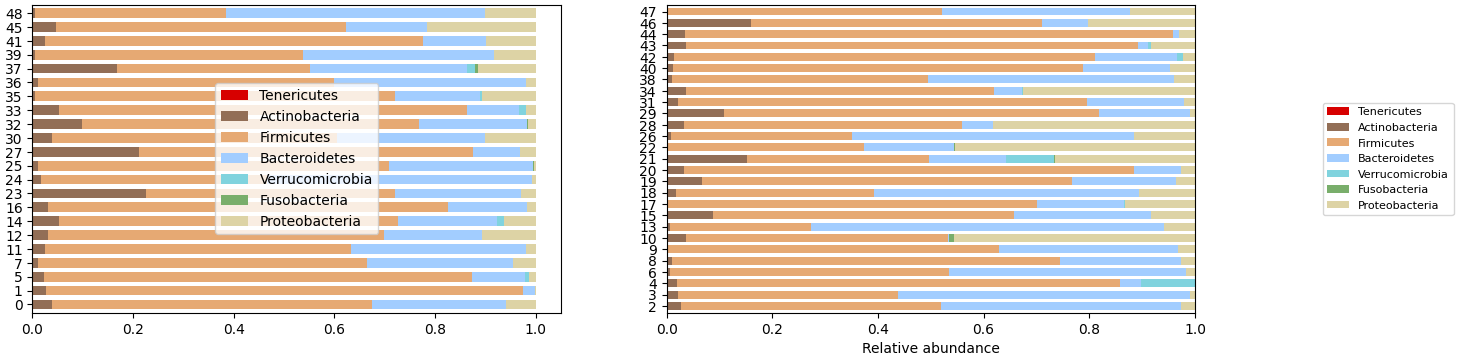

In [23]:
order = collapse_otu(OTU_data, 2)

order.columns = [var.split(';')[-1] for var in order.columns]
tmp = pd.merge(carb_sensitivity_df,order,left_on='ID',right_index=True)
high = tmp.loc[tmp['carb_sen']=='high responder',order.columns]
low = tmp.loc[tmp['carb_sen']=='low responder',order.columns]
#order_bar = pd.DataFrame([high.mean(),low.mean()],index=['high','low'])

fig,ax = plt.subplots(1,2,figsize=(15,4))
high.plot(kind='barh',stacked=True,figsize=(15,4),width=0.7,colormap=cc.cm.glasbey_light,ax=ax[0])
low.plot(kind='barh',stacked=True,figsize=(15,4),width=0.7,colormap=cc.cm.glasbey_light,ax=ax[1])
#for i in range(len(order_bar.columns)):
#    h0 = np.sum([order_bar.iloc[0,k] for k in range(0, i + 1)])
#    h1 = np.sum([order_bar.iloc[1,k] for k in range(0, i + 1)])
#    ax.plot([h0, h1],[0.7 / 2, 1 - 0.7 / 2], color='C7', ls='--', zorder=1,linewidth=0.5)
    
plt.xlim(0,1)
plt.xlabel('Relative abundance')
#plt.yticks([0,1],['High responder','Low responder'],rotation=0)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 0.7),fontsize = 8)
plt.show()

In [8]:
selected_order = list(collapse_otu(OTU_data[microbiome_col], 4).columns)
order = collapse_otu(OTU_data, 4)

# selected에 없는 건 Other로 분류
order['Others'] = order.drop(selected_order,axis=1).sum(axis=1)
order = order[selected_order+['Others']]

order.columns = [var.split(';')[-1] for var in order.columns]
tmp = pd.merge(carb_sensitivity_df,order,left_on='ID',right_index=True)
high = tmp.loc[tmp['carb_sen']=='high responder',order.columns]
low = tmp.loc[tmp['carb_sen']=='low responder',order.columns]
order_bar = pd.DataFrame([high.mean(),low.mean()],index=['high','low'])
ax=order_bar.plot(kind='barh',stacked=True,figsize=(4,3),width=0.7,colormap=cc.cm.glasbey_light)

for i in range(len(order_bar.columns)):
    h0 = np.sum([order_bar.iloc[0,k] for k in range(0, i + 1)])
    h1 = np.sum([order_bar.iloc[1,k] for k in range(0, i + 1)])
    ax.plot([h0, h1],[0.7 / 2, 1 - 0.7 / 2], color='C7', ls='--', zorder=1,linewidth=0.5)
    
plt.xlim(0,1)
plt.xlabel('Relative abundance')
plt.yticks([0,1],['High responder','Low responder'],rotation=0)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 0.7),fontsize = 8)
plt.show()

0.13.0


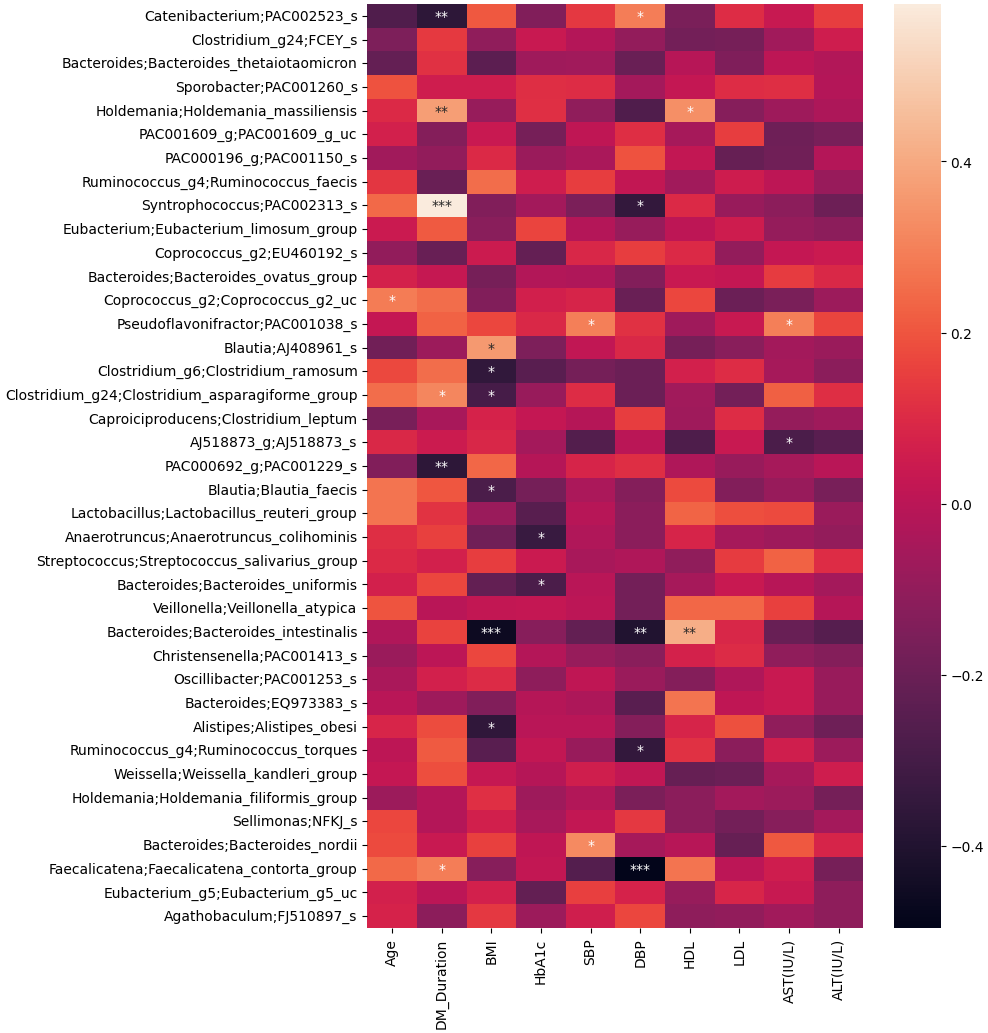

In [279]:
tmp = pd.merge(OTU_data_bc[microbiome_col_],clinical_data[['ID']+cli_col],left_index=True,right_on='ID').set_index('ID')
corr = tmp.corr()
pval = tmp.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*corr.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))

plt.figure(figsize=(8,12))
sns.heatmap(corr.loc[microbiome_col_,cli_col],annot=p.loc[microbiome_col_,cli_col],fmt="")
plt.savefig('../figure/cli_microbiome_corr.jpeg',dpi=300,bbox_inches='tight')
plt.show()

In [306]:
np.linspace(start, end, len(microbiome_col_))

array([ 45.        ,  47.36842105,  49.73684211,  52.10526316,
        54.47368421,  56.84210526,  59.21052632,  61.57894737,
        63.94736842,  66.31578947,  68.68421053,  71.05263158,
        73.42105263,  75.78947368,  78.15789474,  80.52631579,
        82.89473684,  85.26315789,  87.63157895,  90.        ,
        92.36842105,  94.73684211,  97.10526316,  99.47368421,
       101.84210526, 104.21052632, 106.57894737, 108.94736842,
       111.31578947, 113.68421053, 116.05263158, 118.42105263,
       120.78947368, 123.15789474, 125.52631579, 127.89473684,
       130.26315789, 132.63157895, 135.        ])

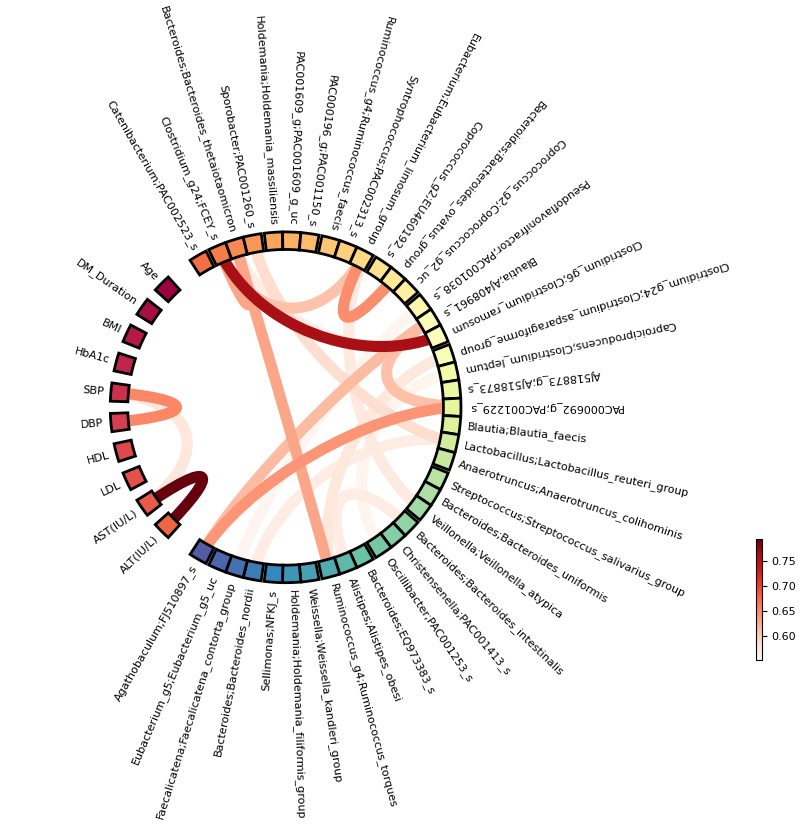

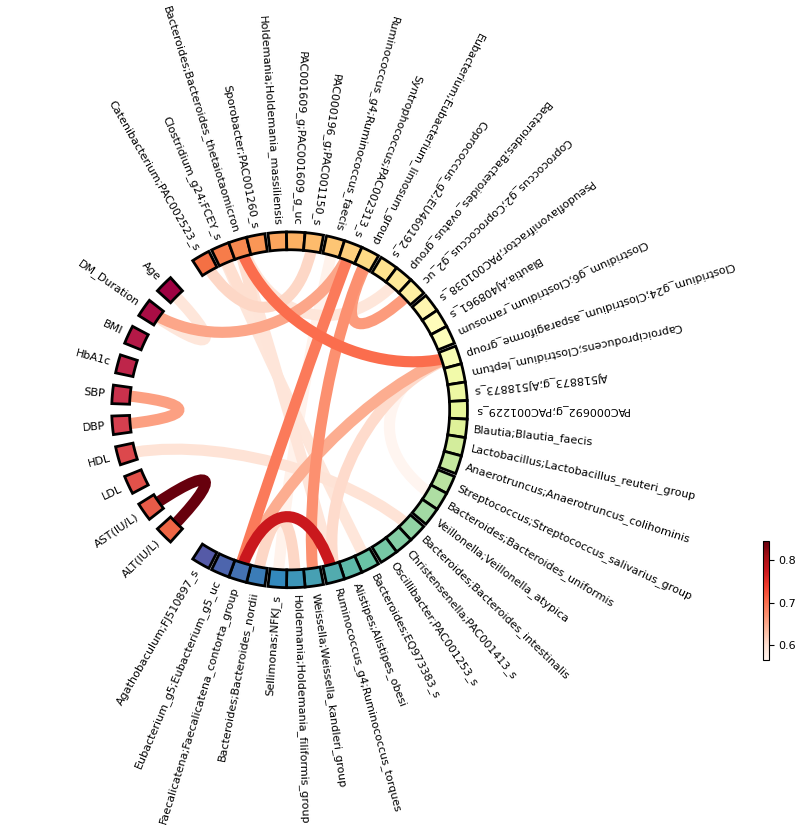

In [317]:
import mne
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
tmp = pd.merge(OTU_data_bc[microbiome_col_],clinical_data[['ID']+cli_col],left_index=True,right_on='ID').set_index('ID')
tmp = pd.merge(carb_sensitivity_df,tmp,on='ID',how='left')
high = tmp.loc[tmp['carb_sen']=='high responder',cli_col+microbiome_col_]
low = tmp.loc[tmp['carb_sen']=='low responder',cli_col+microbiome_col_]

start, end = 45, 135
first_half = (np.linspace(start, end, len(cli_col)) + 90).astype(int)[::+1] % 360
second_half = (np.linspace(-30, 210, len(microbiome_col_)) - 90).astype(int)[::-1] % 360
node_angles = np.array(list(first_half) + list(second_half))


high_corr = np.where(np.array(high.corr()) > 0.55, np.array(high.corr()), np.nan)
fig, axes = plot_connectivity_circle(high_corr, cli_col+microbiome_col_,node_angles=node_angles,linewidth=8,facecolor='white', textcolor='black',colormap='Reds')

low_corr = np.where(np.array(low.corr()) > 0.55, np.array(low.corr()), np.nan)
fig, axes = plot_connectivity_circle(low_corr, cli_col+microbiome_col_,node_angles=node_angles,linewidth=8,facecolor='white', textcolor='black',colormap='Reds')

In [333]:
continuous_var = ['Age','DM_Duration','BMI','SBP','DBP','HbA1c','HDL','LDL','AST(IU/L)','ALT(IU/L)']

cont_var_df = pd.DataFrame(columns=['var'])
for i, var in enumerate(continuous_var):
    cont_var_df.loc[i,'var'] = var
    cont_var_df.loc[i,'High responder'] = str(np.round(np.mean(high[var]),1))+' ± '+str(np.round(np.std(high[var]),2))
    cont_var_df.loc[i,'Low responder'] = str(np.round(np.mean(low[var]),1))+' ± '+str(np.round(np.std(low[var]),2))
    #t-test
    res = stats.ttest_ind(high[var],low[var])#.dropna(subset=var)
    cont_var_df.loc[i,'p-value'] = res.pvalue
cont_var_df

var High responder  Low responder   p-value
0          Age    64.7 ± 8.84    64.3 ± 6.97  0.865058
1  DM_Duration    18.5 ± 7.88    16.7 ± 8.03  0.447765
2          BMI    25.4 ± 2.63    25.7 ± 3.25  0.715056
3          SBP  125.2 ± 10.69  124.9 ± 12.67  0.942438
4          DBP    74.6 ± 6.13    76.0 ± 9.29  0.540675
5        HbA1c     7.7 ± 0.43     8.0 ± 0.53  0.147583
6          HDL    44.9 ± 9.45    43.9 ± 8.39  0.709911
7          LDL   73.1 ± 20.92   76.0 ± 20.22  0.632283
8    AST(IU/L)    25.0 ± 9.26    23.9 ± 9.18  0.692867
9    ALT(IU/L)   27.7 ± 13.96   28.7 ± 16.02  0.812370